# Intro

## Standard modules

In [1]:
import os, sys, pickle
import pathlib
import requests

In [2]:
import numpy as np

In [3]:
from tqdm.auto import tqdm, trange

In [4]:
from sentence_transformers import util

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [67]:
import matplotlib.patches as patches

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.metrics import v_measure_score

In [8]:
import seaborn as sns

In [9]:
import pymannkendall as mk

In [10]:
from scipy.spatial.distance import cosine

In [11]:
import requests
import re
from bs4 import BeautifulSoup  # Per pulizia HTML nelle REST API

In [12]:
import datetime as dt

## Personal modules

In [13]:
from toolbox.updater import time_is_now

In [14]:
from file2text import file2text

In [15]:
from first_rough_cleaning import first_text_cleaner

In [16]:
from file_handler import *

In [17]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [18]:
from tabulate import tabulate

## Folders

In [19]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [20]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [21]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/abtt5_vectors/'

## Sector helper

In [22]:
rtf_files=os.listdir('./rtf')
rtf_files.sort()

In [23]:
sec_helper={}
for file in rtf_files:
    splitted_name=file.split('_')
    if splitted_name[0].isnumeric():
        if splitted_name[0] not in sec_helper.keys():
            sec_helper[splitted_name[0].zfill(2)]=splitted_name[1]

In [24]:
sec_helper

{'10': 'Telecommunications',
 '11': 'Utilities',
 '01': 'Basic Materials',
 '02': 'Consumer Discretionary',
 '03': 'Consumer Staples',
 '04': 'Energy',
 '05': 'Financials',
 '06': 'Health Care',
 '07': 'Industrials',
 '08': 'Real Estate',
 '09': 'Technology'}

### Aggregated sectors

In [25]:
agg_secs={'A': {'name':'Consumer Goods', 'sectors':['02', '03']}, 
 'B':{'name':'Essential Infrastructure & Services', 'sectors':['08', '10', '11']}, 
 'C':{'name':'Production Sectors','sectors':['01', '04', '07']},
 'D':{'name':'Specialized Services','sectors':['05', '06', '09']}}

In [26]:
sec2agg_d={'01':'C', '02':'A', '03':'A', '04':'C', '05':'D', '06':'D', '07':'C', '08':'B', '09':'D', '10':'B', '11':'B'}

## SDG helper

In [27]:
sdg_helper={'01':'No Poverty', 
 '02': 'Zero hunger', 
 '03': 'Good health and well-being', 
 '04': 'Quality education',
 '05': 'Gender equality',
 '06': 'Clean water and sanitation',
 '07': 'Affordable and clean energy',
 '08': 'Decent work and economic growth',
 '09': 'Industry, Innovation, Technology and Infrastructure',
 '10': 'Reduced inequality',
 '11': 'Sustainable cities and communities',
 '12': 'Responsible consumption and production',
 '13': 'Climate action',
 '14': 'Life below water',
 '15': 'Life on land',
 '16': 'Peace, justice and strong institutions',
 '17': 'Partnerships for the goals'
}

## Load vectors

In [28]:
vecfiles=os.listdir(PCA_CENTR_VECTOR_FOLDER)

In [29]:
vecfiles.sort()

### Reports' vectors

In [30]:
reports_files=[vecfile for vecfile in vecfiles if vecfile[:4].isnumeric()]

In [31]:
reports_files.sort()

In [32]:
years, k_y=np.unique([rf[:4] for rf in reports_files], return_counts=True)

In [33]:
np.vstack((years, k_y)).T

array([['2015', '40'],
       ['2016', '44'],
       ['2017', '51'],
       ['2018', '56'],
       ['2019', '67'],
       ['2020', '69'],
       ['2021', '76'],
       ['2022', '80'],
       ['2023', '90']], dtype='<U21')

In [34]:
vectors=np.zeros(len(reports_files), dtype=[('year', 'i4'), ('sector', 'U2'), ('company', 'U100'), ('vector', object)])

In [35]:
for i_rf, reports_file in enumerate(reports_files):
    # info from the filename
    splitted_filename=reports_file.split('_')
    
    year=int(splitted_filename[0])
    sector=splitted_filename[1]
    if splitted_filename[-1]=='PLC.txt':
        company='_'.join(splitted_filename[2:-1])
    else:
        company='_'.join(splitted_filename[2:])
        company=company.replace('.txt', '')
    company=company.lower()
    # get the vector
    vector=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+reports_file)
    
    # organize data
    vectors[i_rf]['year']=year
    vectors[i_rf]['sector']=sector
    vectors[i_rf]['company']=company
    vectors[i_rf]['vector']=vector

### Reports aggregated per sector per year

For each and sector I have an only entry, therefore the final vector has 

In [36]:
_tracks=np.unique(vectors[['year', 'sector']])
l_aggr_rep=len(_tracks)
l_aggr_rep

96

entries.

In [37]:
aggr_vectors=np.zeros(l_aggr_rep, dtype=[('year', 'i4'), ('sector', 'U2'), ('vector', object)])

In [38]:
for i_t, _track in enumerate(tqdm(_tracks)):
    year=_track[0]
    sector=_track[1]
    # select entries in vectors
    _mask=np.logical_and(vectors['year']==year, vectors['sector']==sector)
    _selection=vectors[_mask]
    # define te entries in aggr_vectors
    aggr_vectors[i_t]['year']=year
    aggr_vectors[i_t]['sector']=sector
    aggr_vectors[i_t]['vector']=np.mean(_selection['vector'])

  0%|          | 0/96 [00:00<?, ?it/s]

### Reports aggregated per aggregated sector per year

For each and sector I have an only entry, therefore the final vector has 

In [39]:
l_aggr_aggsec=4*len(years)
l_aggr_aggsec

36

entries.

In [40]:
aggsec_aggr_vectors=np.zeros(l_aggr_aggsec, dtype=[('year', 'i4'), ('agg_sec', 'U2'), ('vector', object)])

In [41]:
index=0
for year in tqdm(years):
    for i in range(4):
        _agg=chr(i+ord('A'))
        _agg_sectors=agg_secs[_agg]['sectors']
        # select entries in vectors
        _mask=np.logical_and(vectors['year']==year, np.isin(vectors['sector'],_agg_sectors))
        _selection=vectors[_mask]
        # define the entries in aggr_vectors
        aggsec_aggr_vectors[index]['year']=year
        aggsec_aggr_vectors[index]['agg_sec']=_agg
        aggsec_aggr_vectors[index]['vector']=np.mean(_selection['vector'])
        index+=1

  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_11361/503975990.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  _mask=np.logical_and(vectors['year']==year, np.isin(vectors['sector'],_agg_sectors))
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


### Witten's vector

In [42]:
wittenvecfile=[file for file in os.listdir(PCA_CENTR_VECTOR_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [43]:
wittenvec=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+wittenvecfile)

### Goals' vectors

In [44]:
goalvecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('Goal')]

In [45]:
goalvecfiles.sort()

In [46]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [47]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Wikipedia's vectors

In [48]:
wikivecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('wiki')]

In [49]:
wikivecfiles.sort()

In [50]:
len(wikivecfiles)

4001

In [51]:
wikivecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+wikivecfile) for wikivecfile in wikivecfiles]

## FDR

In [52]:
def fdr_th(p_vals, alpha):
    _aux=np.sort(p_vals)
    fdr_ths=np.arange(1, 1+len(_aux))*alpha/len(_aux)
    fdr_mask=_aux<=fdr_ths
    if np.sum(fdr_mask)>0:
        return fdr_ths[fdr_mask][-1]
    else:
        return 0.

# Internal similarity

## The benchmark

In [53]:
years=years.astype('i4')

In [55]:
with open('./NewProcessedData/wiki_benchmark_abtt5.pickle', 'rb') as f:
    wiki_bench=pickle.load(f)

## Internal similarity among reports, per year

In [62]:
len(vectors[0]['vector'])

768

In [69]:
cos_rep_mats={}
for year in tqdm(years):
    vec_y=vectors[vectors['year']==year]
    dim_y=len(vec_y)
    cos_mat=np.ones((dim_y, dim_y))
    for i_s in range(len(vec_y)):
        for j_s in range(i_s+1, len(vec_y)):
            vec_0=vec_y[i_s]['vector']
            vec_1=vec_y[j_s]['vector']
            cos_mat[i_s, j_s]=float(util.cos_sim(vec_0, vec_1))
            cos_mat[j_s, i_s]=cos_mat[i_s, j_s]
    cos_rep_mats[year]=cos_mat

  0%|          | 0/9 [00:00<?, ?it/s]

In [95]:
comp_y={}
sect_y={}
for year in tqdm(years):
    vec_y=vectors[vectors['year']==year]
    comp_y[year]=vec_y['company'].copy()
    sect_y[year]=vec_y['sector'].copy()

  0%|          | 0/9 [00:00<?, ?it/s]

### Plot

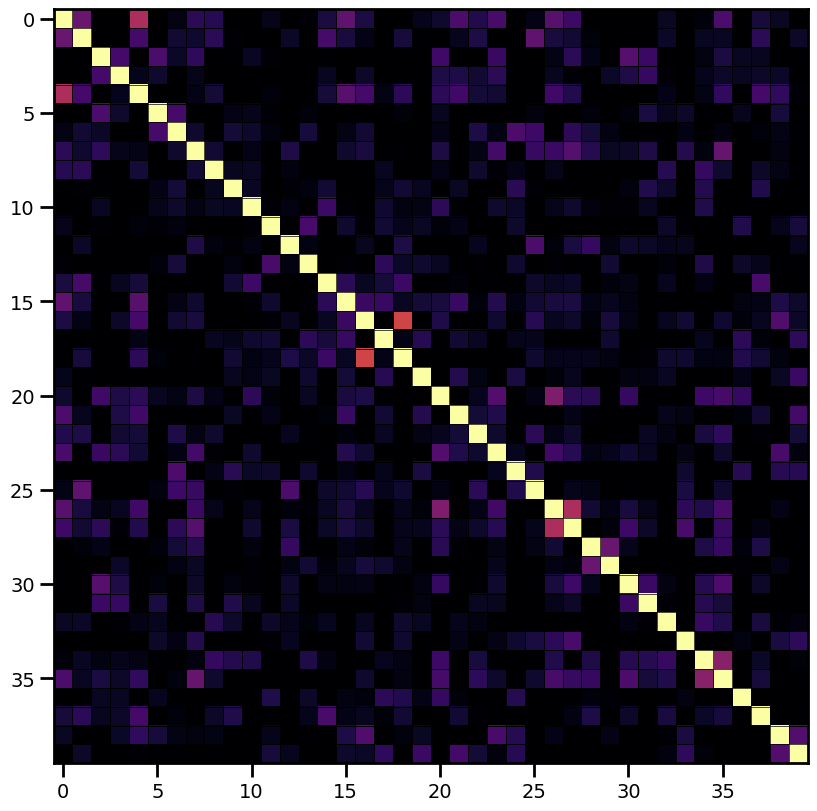

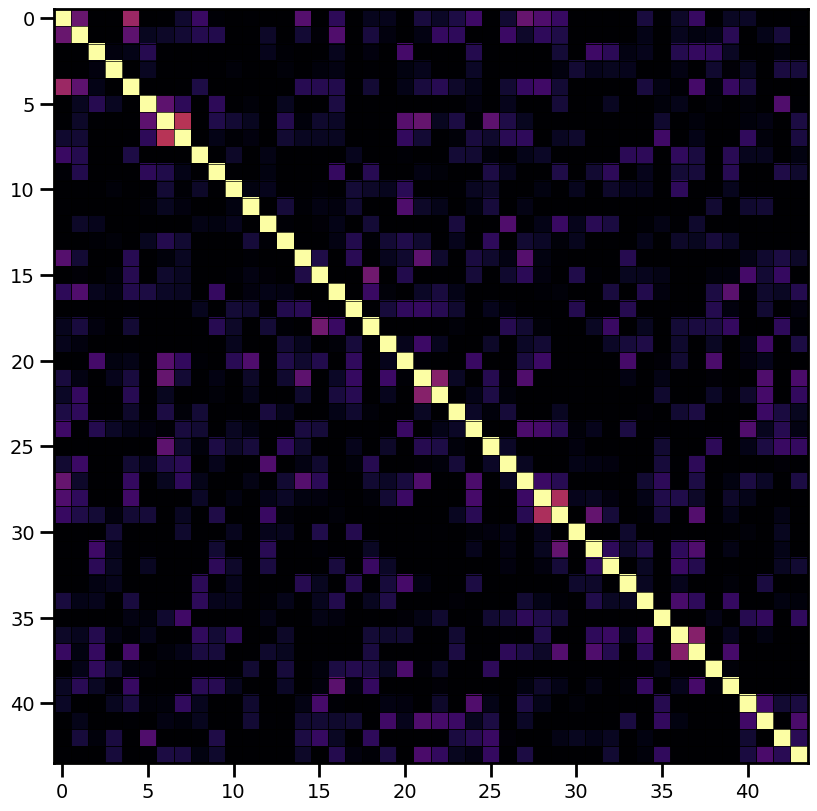

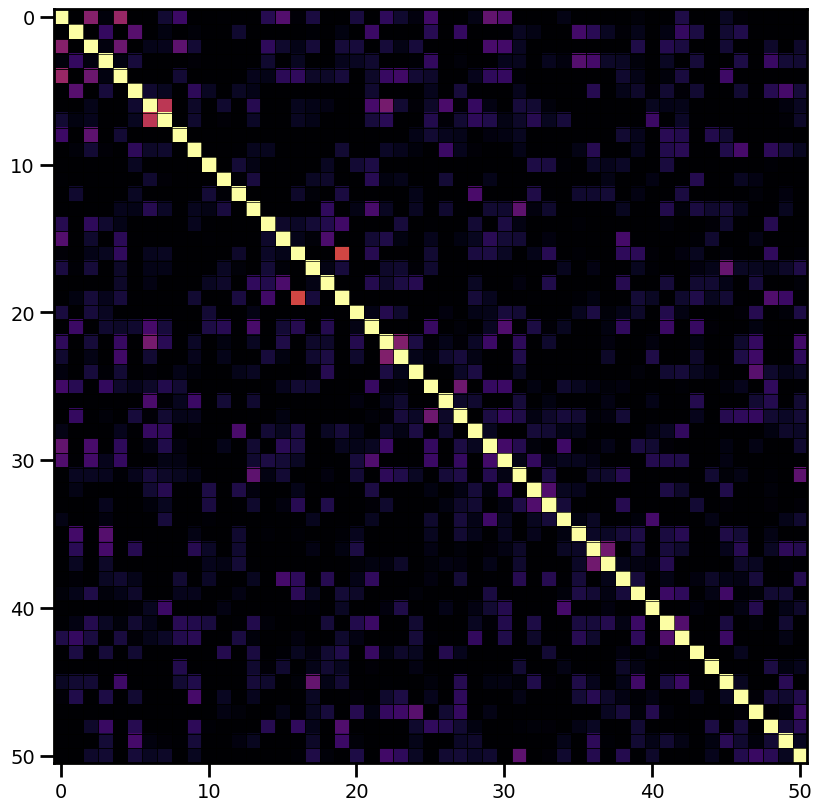

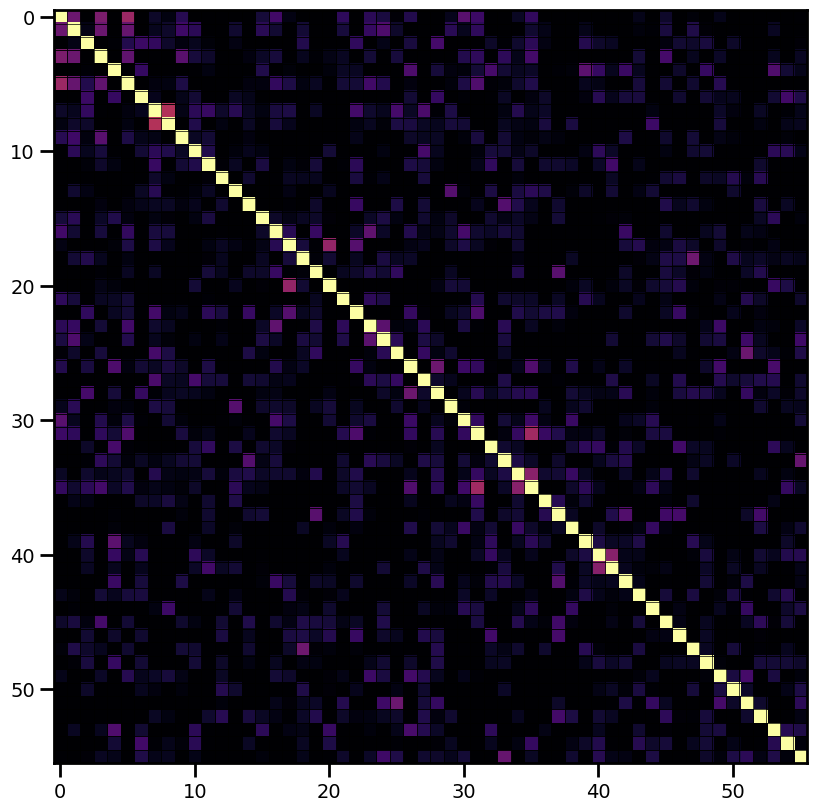

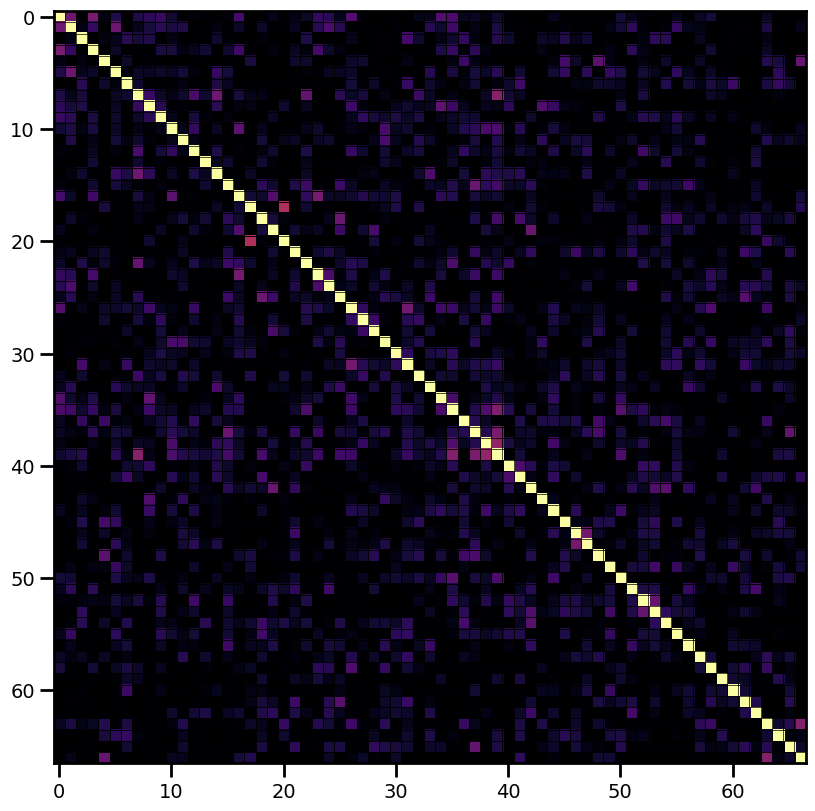

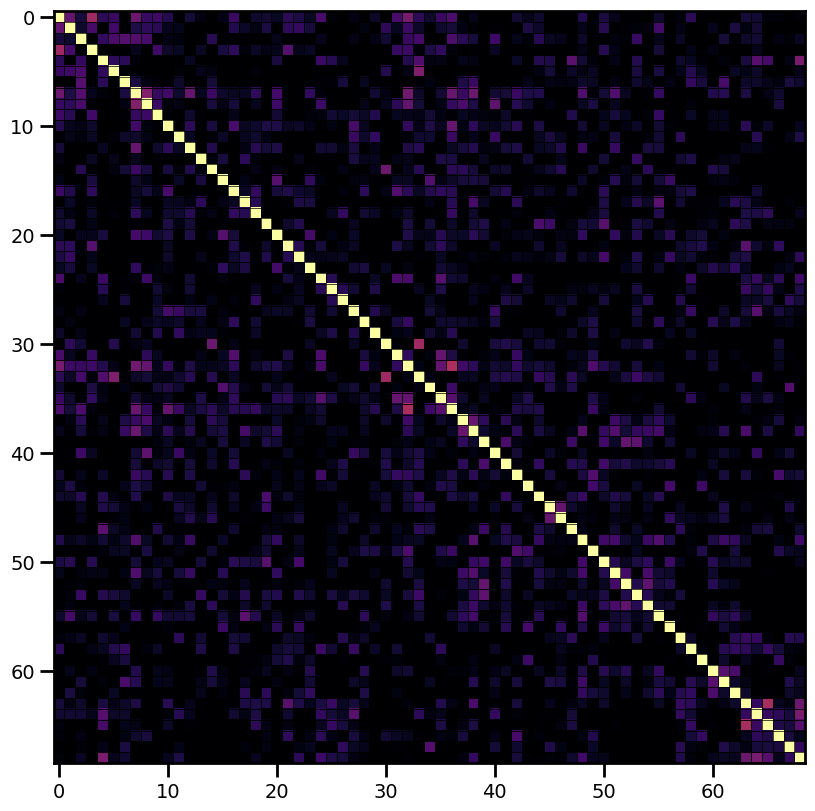

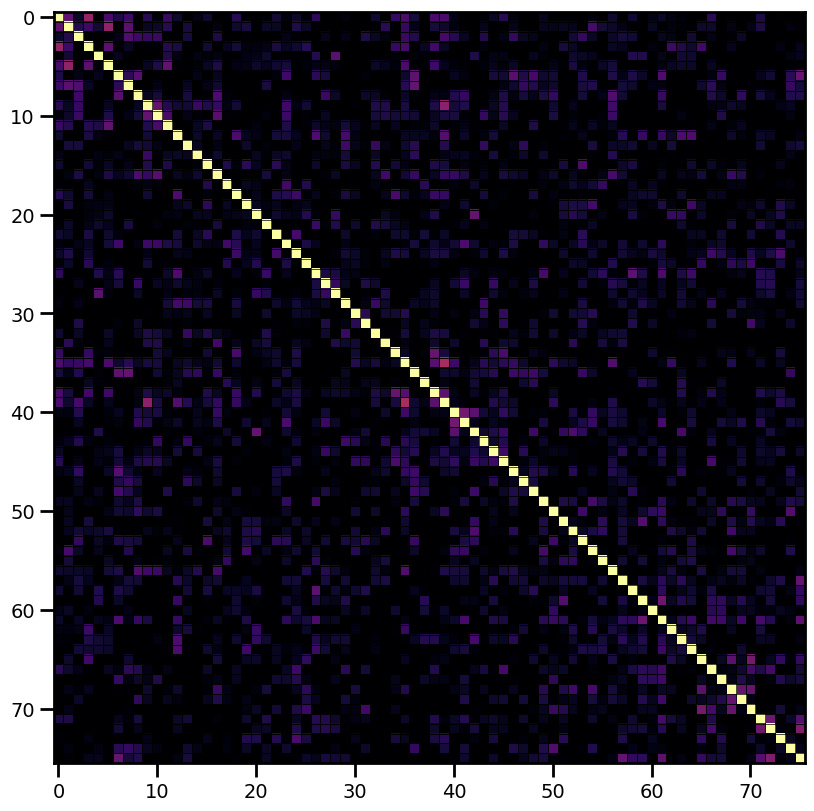

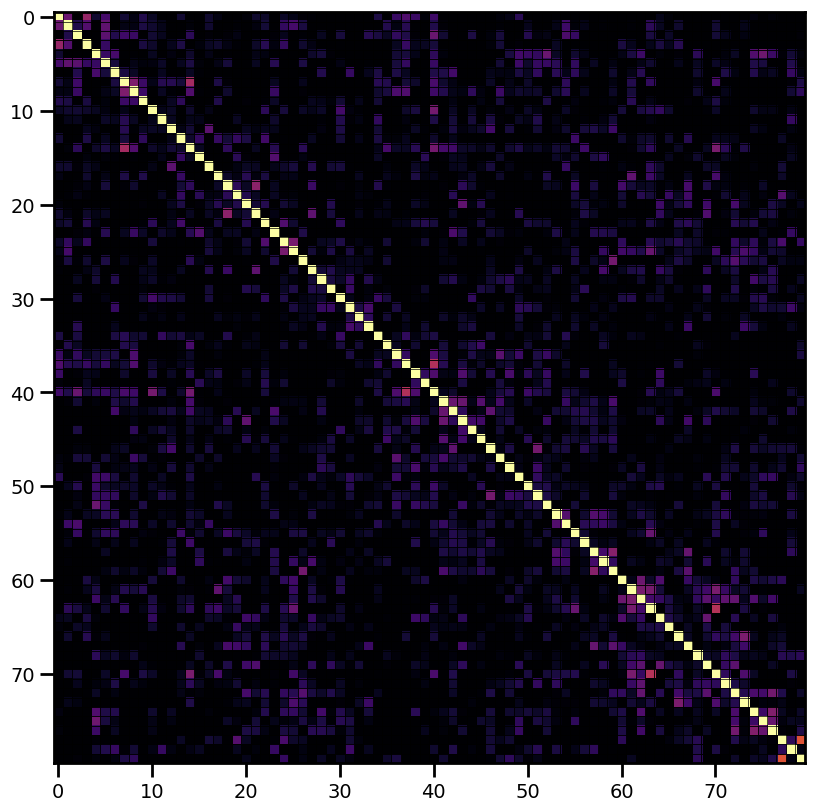

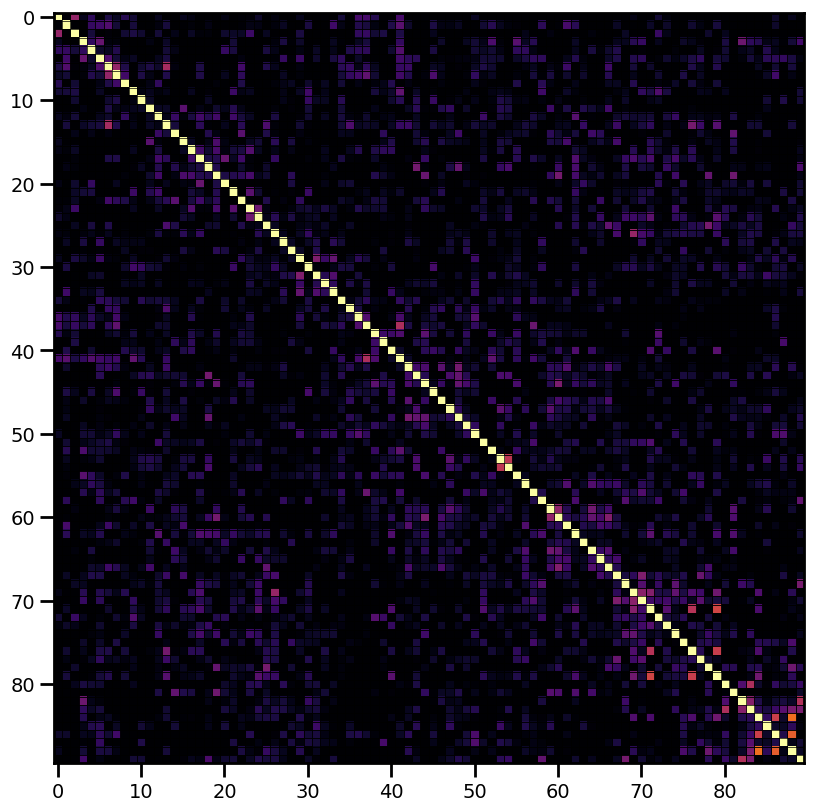

In [79]:
for year in years:
    fig = plt.figure(figsize=(11, 8), constrained_layout=True)
    plt.imshow(cos_rep_mats[year], cmap='inferno', vmin=0, vmax=1)#, alpha=alpha_matrix_0)
    
    ax = plt.gca()

    # Etichette

    vec_y=vectors[vectors['year']==year]
    n=len(vec_y)
    #names=vec_y['company']
    
    #plt.xticks(np.arange(n), labels=names, rotation=90)
    #plt.yticks(np.arange(n), labels=names)

    # Annotazioni numeriche
    for i in range(n):
        for j in range(i+1, n):
            val = cos_rep_mats[year][i, j]
            #plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            #plt.text(i, j, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            
            # Riquadri neri su ogni cella: triangolo superiore
            rect = patches.Rectangle((j - 0.5, i - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            
            # Riquadri neri su ogni cella: triangolo inferiore
            rect = patches.Rectangle((i - 0.5, j - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            
            
    plt.grid(False)

    
    plt.show()

### Validating p-values

In [83]:
val_pvals={}
for year in tqdm(years, leave=False):
    n=len(cos_rep_mats[year])
    p_vals=np.zeros(n*(n-1), dtype=[('node_0', int), ('node_1', int), ('p_value', float)])
    counter=0
    for i_i_row, i_row in enumerate(cos_rep_mats[year]):
        for j, entry in enumerate(i_row):
            if j!=i_i_row:
                p_vals[counter]['node_0']=i_i_row
                p_vals[counter]['node_1']=j
                p_vals[counter]['p_value']=np.sum(wiki_bench[i_i_row]['cos_sim']>=entry)/4001
                counter+=1
    _fdr_th=fdr_th(p_vals['p_value'], alpha=0.05)
    val_pvals[year]=p_vals[p_vals['p_value']<=_fdr_th]
    n_val_p_vals=len(val_pvals[year])/n/(n-1)
    print(f'{year}) {n_val_p_vals}')

  0%|          | 0/9 [00:00<?, ?it/s]

2015) 0.0858974358974359
2016) 0.06659619450317125
2017) 0.05215686274509804
2018) 0.056168831168831174
2019) 0.045454545454545456
2020) 0.06798806479113384
2021) 0.05210526315789474
2022) 0.06123417721518988
2023) 0.07078651685393259


In [100]:
cacca=['cacca']
cacca.index('cacca')

0

In [111]:
sect_y[year]

array(['01', '01', '01', '01', '01', '01', '02', '02', '02', '02', '02',
       '02', '02', '02', '02', '02', '03', '03', '03', '03', '03', '03',
       '03', '03', '03', '03', '04', '04', '04', '04', '04', '04', '04',
       '04', '04', '05', '05', '05', '05', '05', '05', '05', '06', '06',
       '06', '06', '06', '06', '06', '06', '07', '07', '07', '07', '07',
       '07', '07', '07', '07', '08', '08', '08', '08', '08', '08', '08',
       '08', '09', '09', '09', '09', '09', '09', '09', '10', '10', '10',
       '10', '10', '10', '11', '11', '11', '11', '11', '11', '11', '11',
       '11', '11'], dtype='<U2')

In [114]:
val_couples_sect_y={}
for year in years:
    _edges=[]
    _weights=[]
    for edge in val_pvals[year]:
        _node_0_sect=sect_y[year][edge['node_0']]
        _node_1_sect=sect_y[year][edge['node_1']]
        _l_sect_0=np.sum(sect_y[year]==_node_0_sect)
        _l_sect_1=np.sum(sect_y[year]==_node_1_sect)
        _couple=(_node_0_sect, _node_1_sect)
        if _couple in _edges:
            _index=_edges.index(_couple)
            _weights[_index]+=1/_l_sect_0/_l_sect_1
        else:
            _edges.append(_couple)
            _weights.append(1/_l_sect_0/_l_sect_1)  
    val_couples_sect_y[year]=np.zeros(len(_edges), dtype=[('sect_0', 'U2'), ('sect_1', 'U2'), ('valid_freq', float)])
    val_couples_sect_y[year]['sect_0']=[_edge[0] for _edge in _edges]
    val_couples_sect_y[year]['sect_1']=[_edge[1] for _edge in _edges]
    val_couples_sect_y[year]['valid_freq']=_weights

In [125]:
val_couples_sect_y[2023][val_couples_sect_y[2023]['valid_freq']>.2]

array([('01', '05', 0.23809524), ('03', '03', 0.21      ),
       ('06', '06', 0.234375  ), ('08', '06', 0.21875   ),
       ('08', '08', 0.28125   ), ('09', '09', 0.32653061),
       ('09', '10', 0.28571429), ('10', '09', 0.21428571),
       ('11', '11', 0.29      )],
      dtype=[('sect_0', '<U2'), ('sect_1', '<U2'), ('valid_freq', '<f8')])

In [128]:
sec_helper['09'], sec_helper['10']

('Technology', 'Telecommunications')

In [126]:
sec_helper['01'],sec_helper['03'],sec_helper['05'],sec_helper['06'],sec_helper['08'],sec_helper['09'], sec_helper['10'], sec_helper['11']

('Basic Materials',
 'Consumer Staples',
 'Financials',
 'Health Care',
 'Real Estate',
 'Technology',
 'Telecommunications',
 'Utilities')

In [127]:
sec_helper['03'],sec_helper['06'],sec_helper['08'],sec_helper['09'], sec_helper['11']

('Consumer Staples', 'Health Care', 'Real Estate', 'Technology', 'Utilities')

#### Alpha-matrices

In [166]:
alpha_matrices={}
for year in years:
    n=len(cos_rep_mats[year])
    alpha_matrix=np.ones((n,n))*.6
    for _ in val_pvals[year]:
        i=_['node_0']
        j=_['node_1']
        alpha_matrix[i, j]=1.
    alpha_matrices[year]=alpha_matrix

##### Non-symmetric validation

In [202]:
year=2023

In [191]:
validated_entries=np.vstack(np.where(alpha_matrices[2023]==1.)).T

In [198]:
validated_entries[validated_entries[:, 0]==0][:,1]

array([ 2, 36, 37, 41])

In [199]:
nsym_validatation=[]
for ve in validated_entries:
    ve_n0=ve[0]
    ve_n1=ve[1]
    if ve_n0 not in validated_entries[validated_entries[:, 0]==ve_n1]:
        nsym_validatation.append((ve_n0, ve_n1))

In [204]:
len(nsym_validatation)/len(validated_entries), len(nsym_validatation)

(0.4144620811287478, 235)

In [205]:
n=len(cos_rep_mats[year])
p_vals=np.zeros(n*(n-1), dtype=[('node_0', int), ('node_1', int), ('p_value', float)])
counter=0
for i_i_row, i_row in enumerate(cos_rep_mats[year]):
    for j, entry in enumerate(i_row):
        if j!=i_i_row:
            p_vals[counter]['node_0']=i_i_row
            p_vals[counter]['node_1']=j
            p_vals[counter]['p_value']=np.sum(wiki_bench[i_i_row]['cos_sim']>=entry)/4001
            counter+=1
_fdr_th=fdr_th(p_vals['p_value'], alpha=0.05)    

In [206]:
_fdr_th

0.0035393258426966293

In [210]:
other_pval

array([0.011997])

In [214]:
for edge in nsym_validatation:
    orig_pval=p_vals[np.logical_and(p_vals['node_0']==edge[0], p_vals['node_1']==edge[1])]['p_value'][0]
    other_pval=p_vals[np.logical_and(p_vals['node_1']==edge[0], p_vals['node_0']==edge[1])]['p_value'][0]
    print(f'{orig_pval/other_pval:.2e}')

2.08e-02
6.94e-03
5.65e-02
4.32e-02
0.00e+00
2.68e-03
4.79e-03
4.07e-02
1.87e-01
2.41e-02
1.40e-02
1.43e-01
2.67e-01
1.12e-02
2.50e-01
9.76e-02
1.05e-02
1.67e-01
4.37e-02
0.00e+00
2.19e-01
1.44e-02
3.60e-01
1.47e-02
4.35e-02
7.69e-02
1.56e-01
0.00e+00
0.00e+00
9.16e-02
1.33e-01
1.20e-02
3.51e-02
2.00e-02
2.63e-02
3.81e-01
2.43e-02
6.67e-02
3.45e-02
1.33e-02
1.86e-01
1.29e-01
1.49e-01
5.83e-01
0.00e+00
3.85e-02
7.58e-03
8.06e-02
3.51e-02
4.74e-01
7.72e-03
0.00e+00
8.57e-02
5.22e-01
1.35e-02
7.63e-03
2.94e-02
1.45e-02
1.67e-01
1.51e-02
1.58e-01
2.33e-02
2.02e-02
1.69e-02
2.47e-03
6.89e-03
6.21e-03
2.44e-03
2.04e-02
5.26e-02
0.00e+00
0.00e+00
2.11e-01
1.78e-01
0.00e+00
0.00e+00
6.25e-02
8.93e-03
3.08e-01
1.04e-01
1.90e-02
3.59e-02
2.92e-01
6.67e-02
0.00e+00
6.02e-03
0.00e+00
4.11e-02
1.96e-02
5.01e-03
1.31e-01
8.58e-03
6.00e-02
6.61e-03
3.03e-02
1.85e-02
1.58e-01
1.15e-01
6.22e-03
3.40e-02
8.97e-02
3.48e-01
7.51e-02
2.07e-01
7.07e-02
3.59e-01
1.28e-03
1.03e-02
1.56e-02
1.10e-02
0.00e+00
5

In [246]:
selected_ones=np.random.choice(len(nsym_validatation), 9)

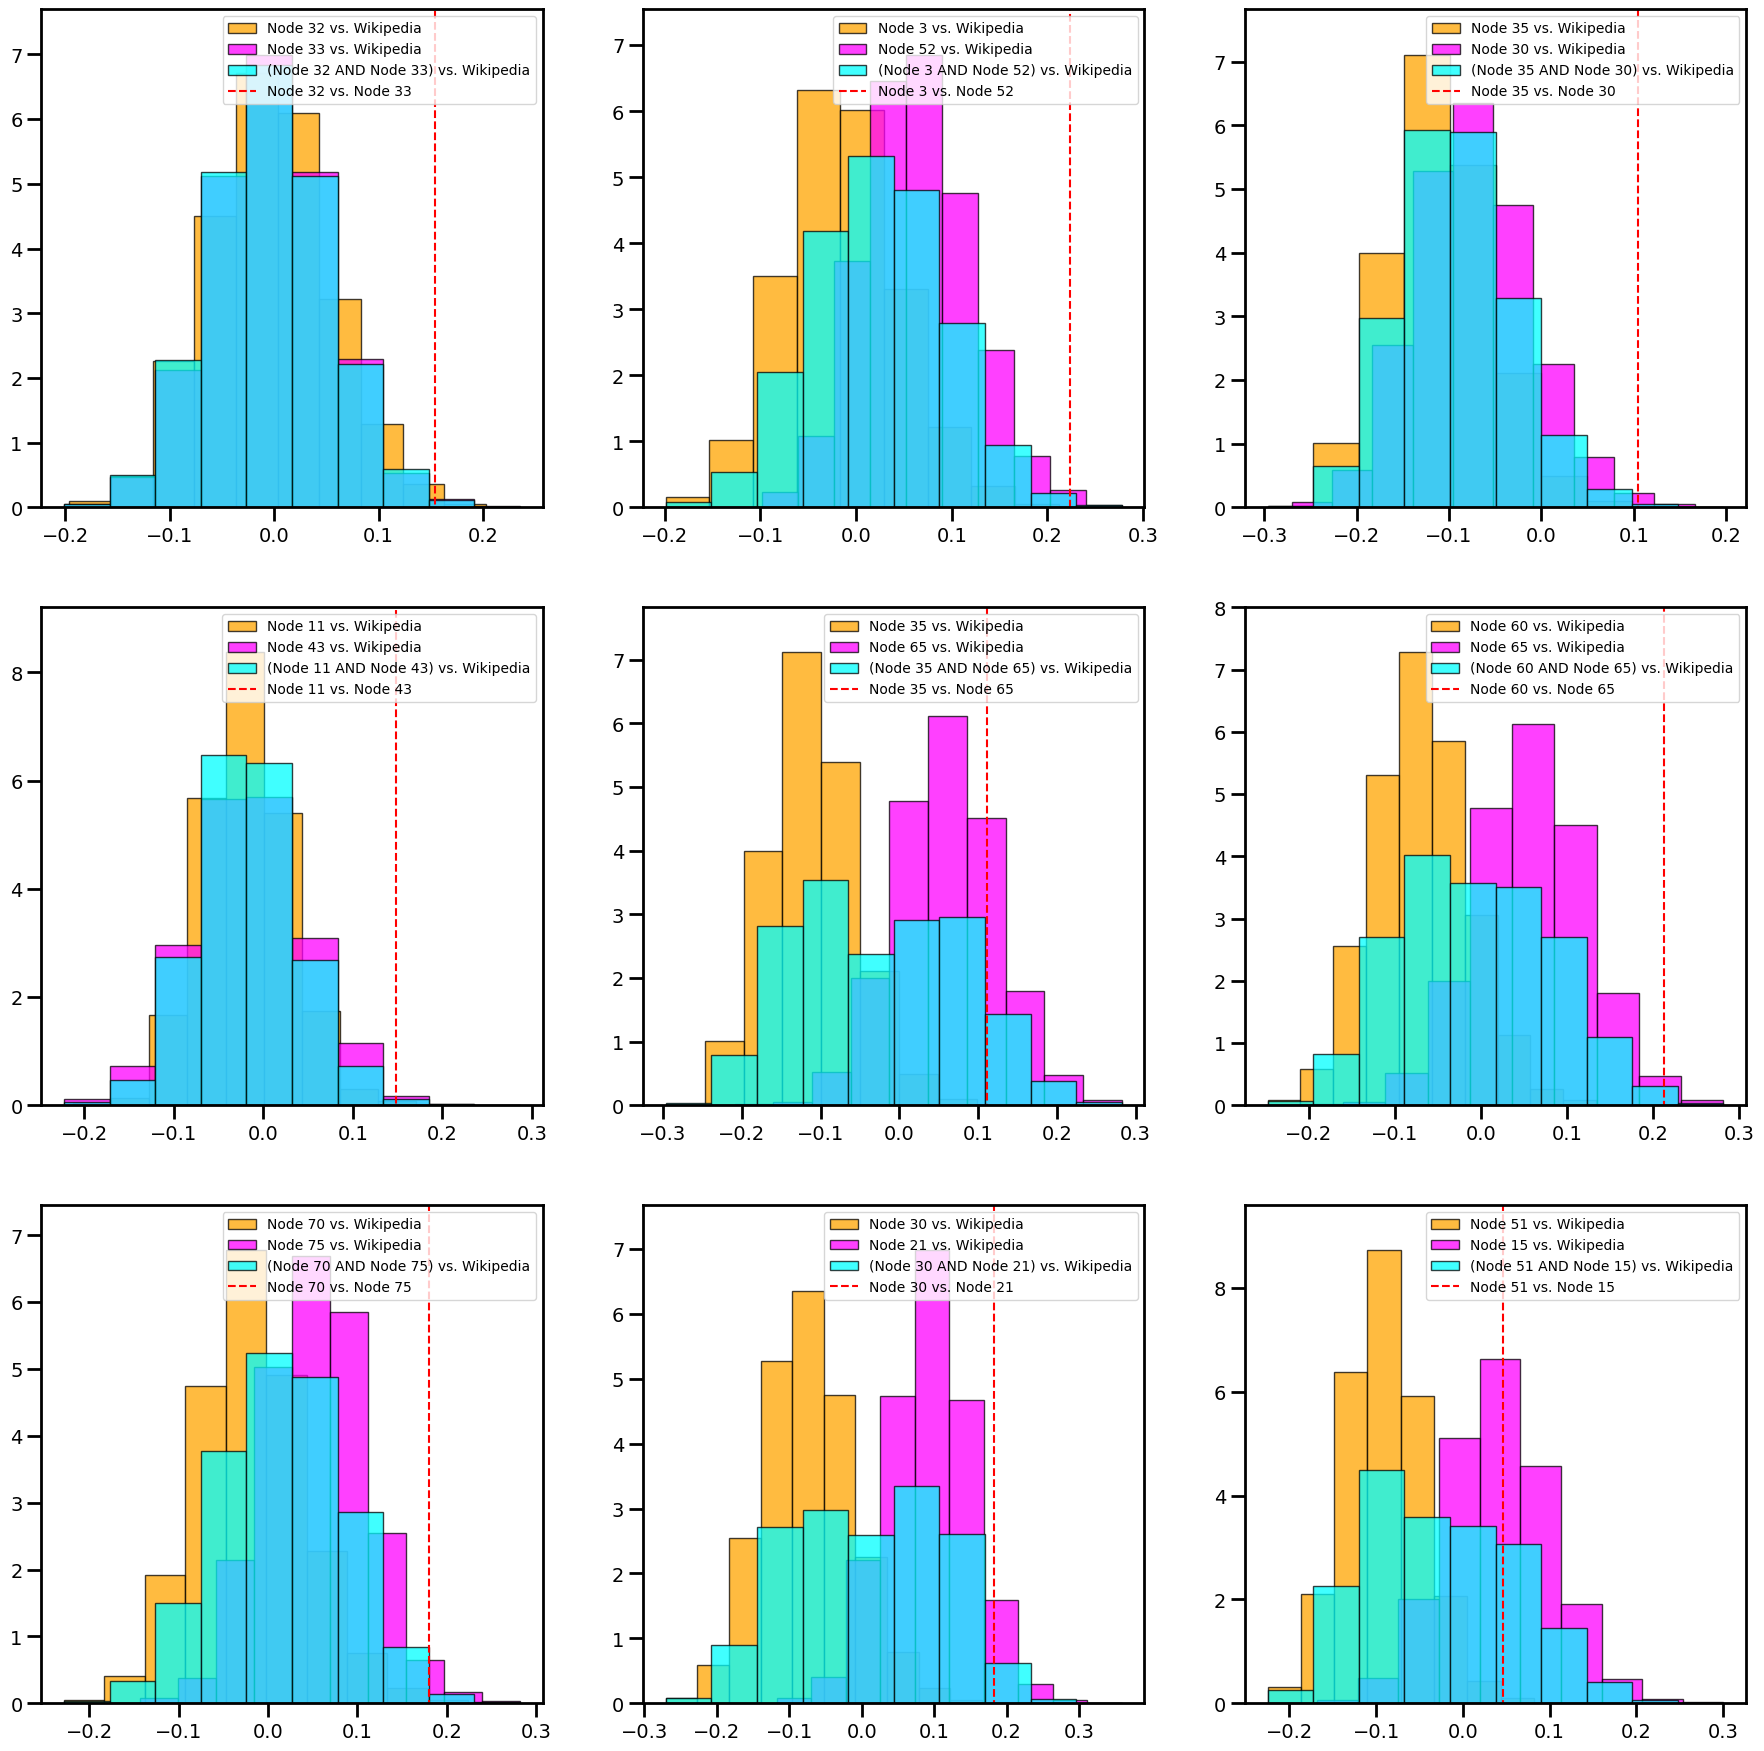

In [261]:
fig, axs=plt.subplots(3,3, figsize=(22, 22))
for _ in range(9):
    i= _ //3
    j= _ % 3
    node_0=nsym_validatation[selected_ones[_]][0]
    node_1=nsym_validatation[selected_ones[_]][1]
    hist_0=axs[i, j].hist(wiki_bench[node_0]['cos_sim'], edgecolor='black', color='orange', label=f'Node {node_0} vs. Wikipedia', alpha=0.75, density=True)
    hist_1=axs[i, j].hist(wiki_bench[node_1]['cos_sim'], edgecolor='black', color='magenta', label=f'Node {node_1} vs. Wikipedia', alpha=0.75, density=True)
    hist_2=axs[i, j].hist(np.concatenate((wiki_bench[node_0]['cos_sim'],wiki_bench[node_1]['cos_sim'])), edgecolor='black', color='cyan', label=f'(Node {node_0} AND Node {node_1}) vs. Wikipedia', alpha=0.75, density=True)
    axs[i, j].vlines(cos_rep_mats[year][node_0,node_1], -2, 10, ls='--', color='red', label=f'Node {node_0} vs. Node {node_1}')
    axs[i, j].legend()
    # get the proper limits
    max_y=1.1*max([np.max(hist_0[0]), np.max(hist_1[0]), np.max(hist_2[0])])
    axs[i, j].set_ylim(0, max_y)
plt.savefig(f'./NewPlots/asym_internal_similarity_reports_example.png', dpi=300)
plt.show()

### Plots, again

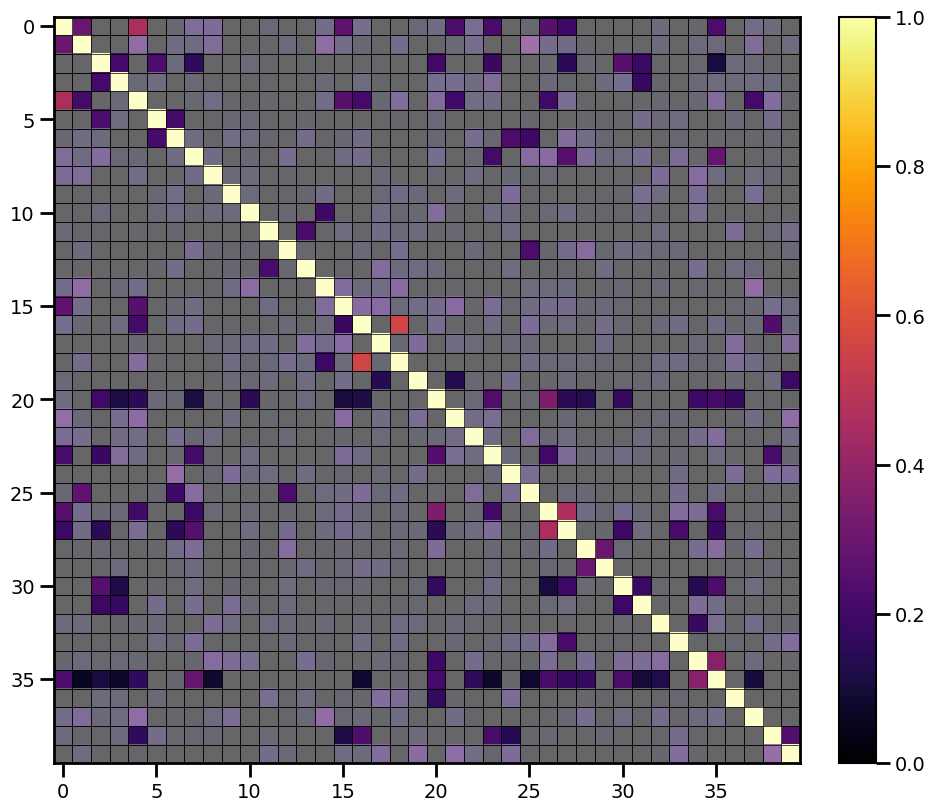

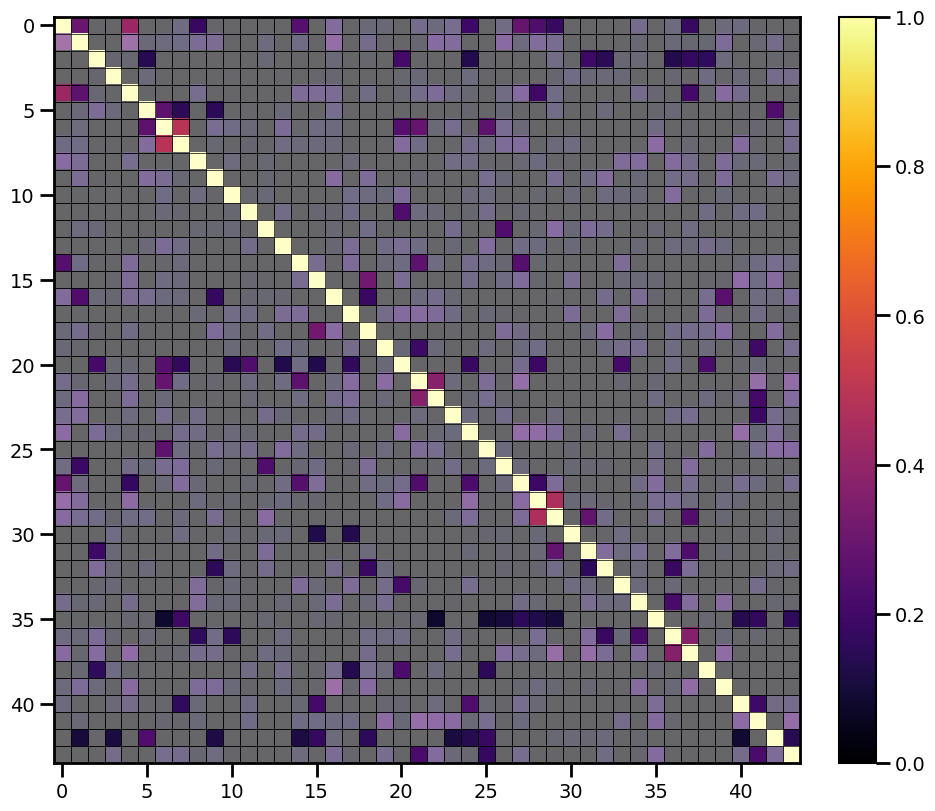

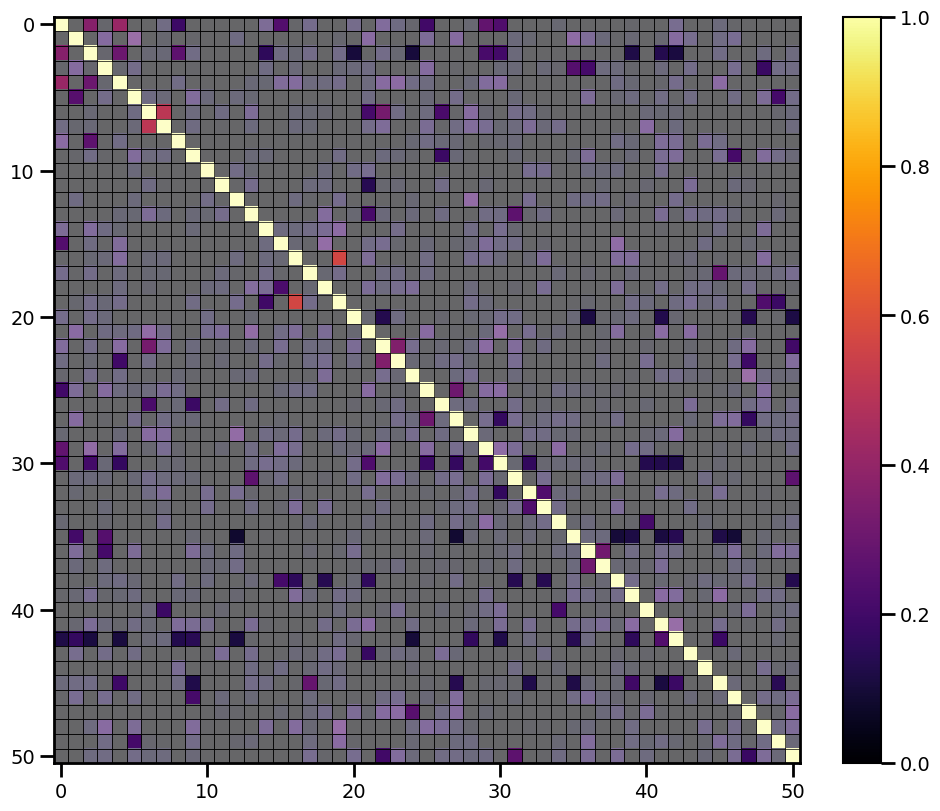

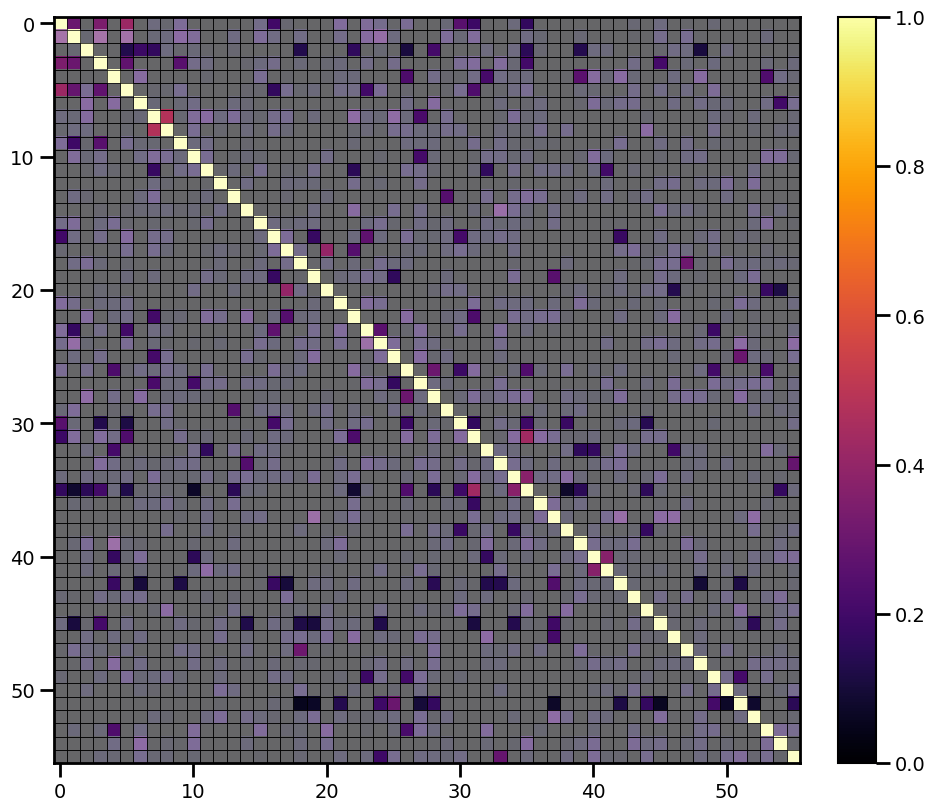

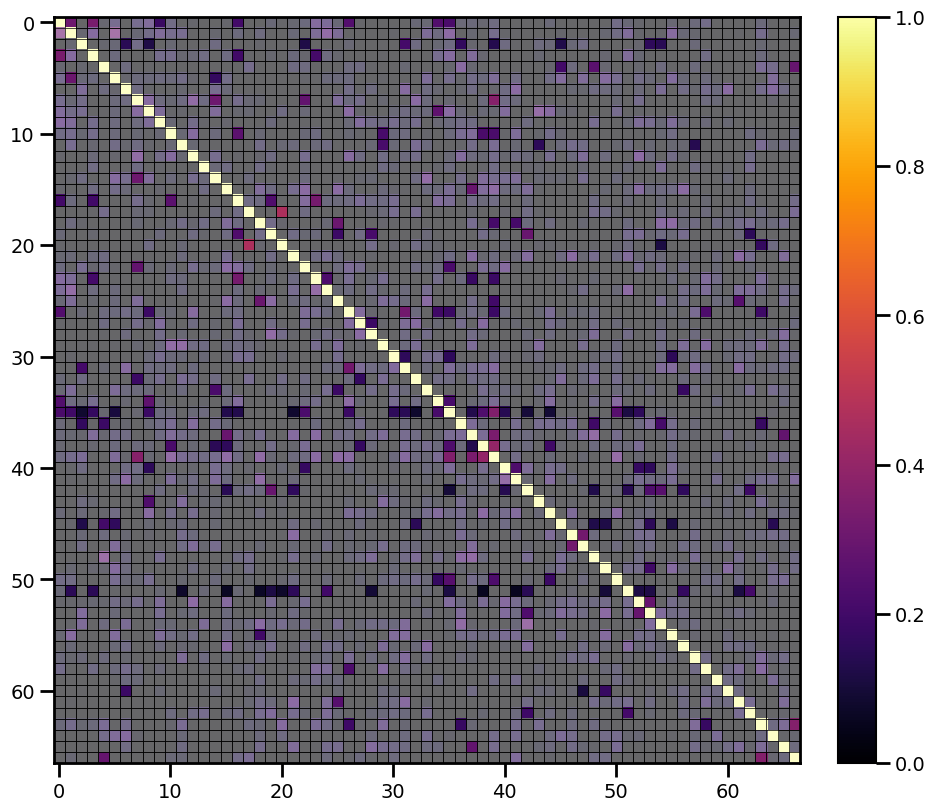

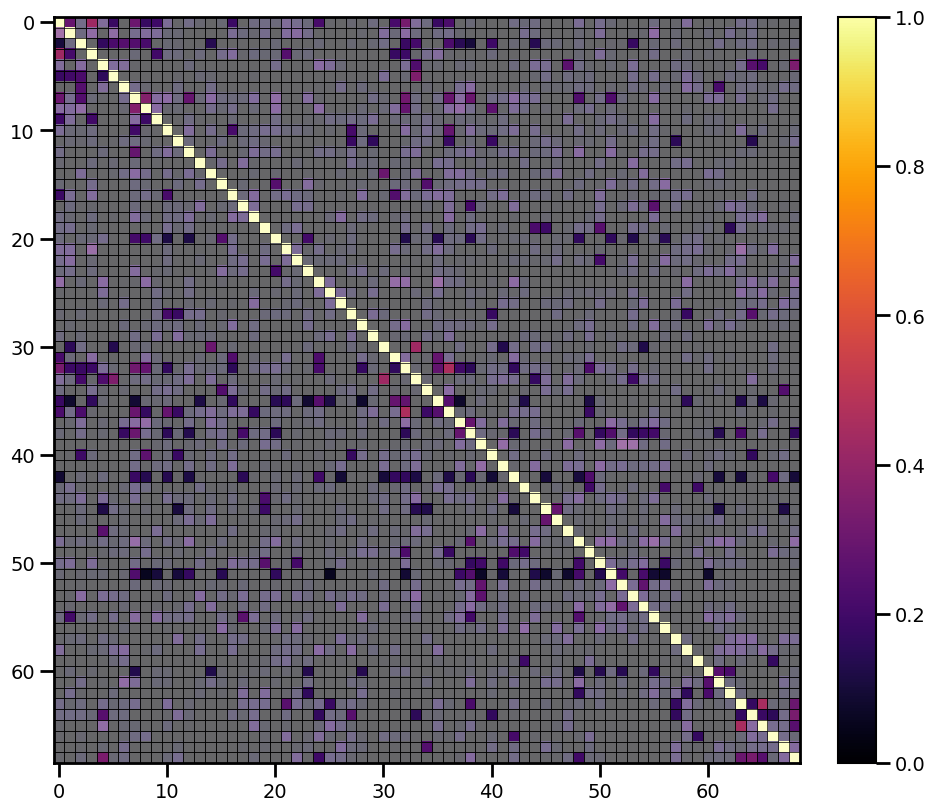

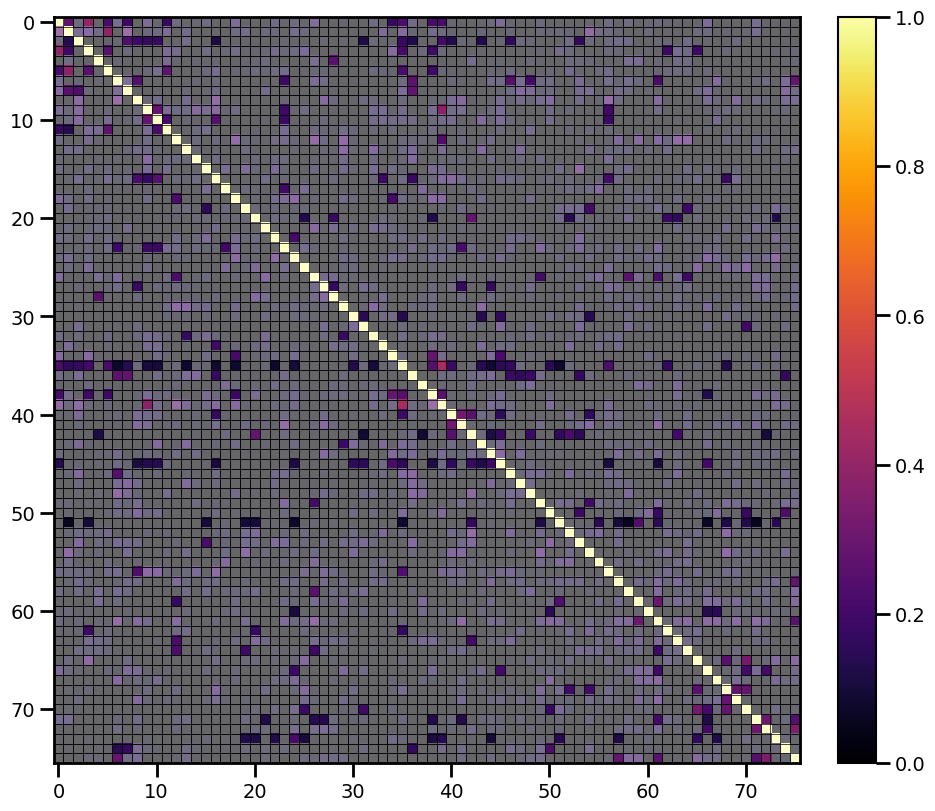

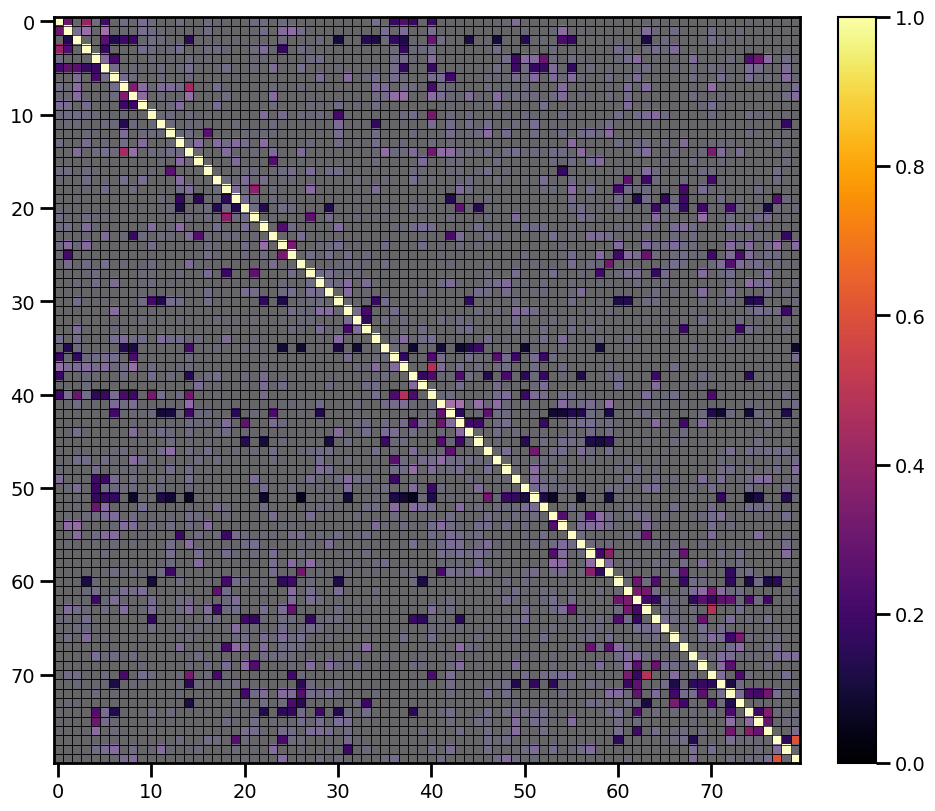

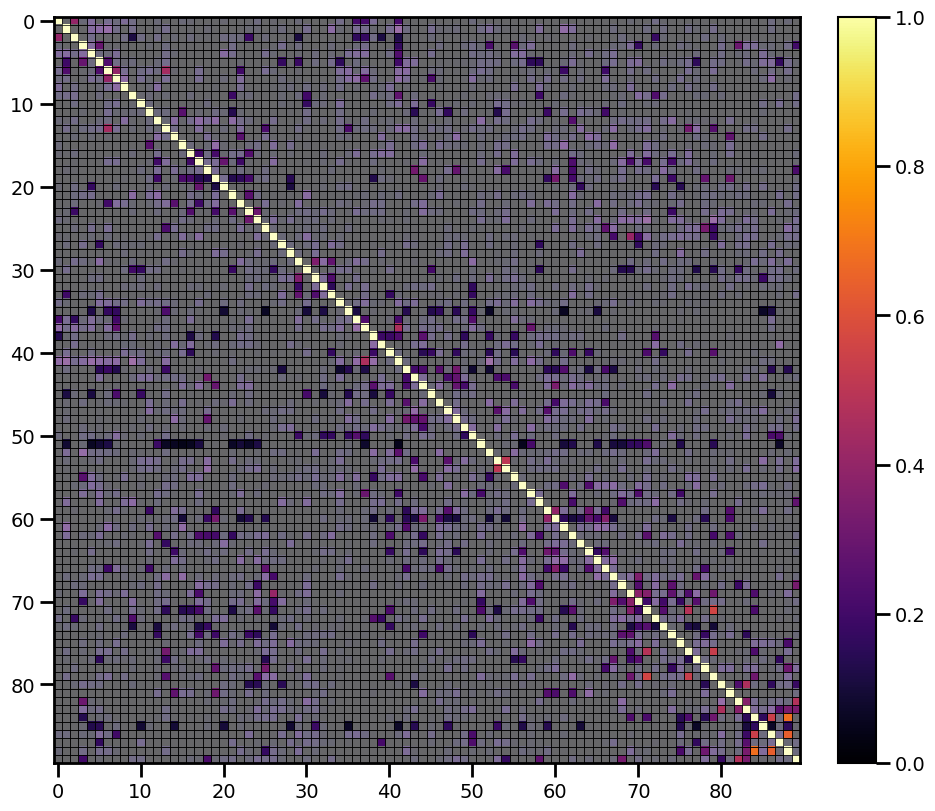

In [167]:
for year in years:
    fig = plt.figure(figsize=(11, 8), constrained_layout=True)
    im = plt.imshow(cos_rep_mats[year], cmap='inferno', vmin=0, vmax=1, alpha=alpha_matrices[year])
    # Rettangoli lime attorno ai blocchi di ax_im0

    ax = plt.gca()
    n=len(cos_rep_mats[year])
    # Annotazioni numeriche
    for i in range(n):
        for j in range(i+1, n):
            val = cos_rep_mats[year][i, j]
            #plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            #plt.text(i, j, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            
            # Riquadri neri su ogni cella: triangolo superiore
            rect = patches.Rectangle((j - 0.5, i - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            
            # Riquadri neri su ogni cella: triangolo inferiore
            rect = patches.Rectangle((i - 0.5, j - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            
            
    plt.grid(False)
    # Colorbar con bordo nero
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1.5)

    plt.savefig(f'./NewPlots/internal_similarity_reports_{year}.png', dpi=300)
    plt.show()

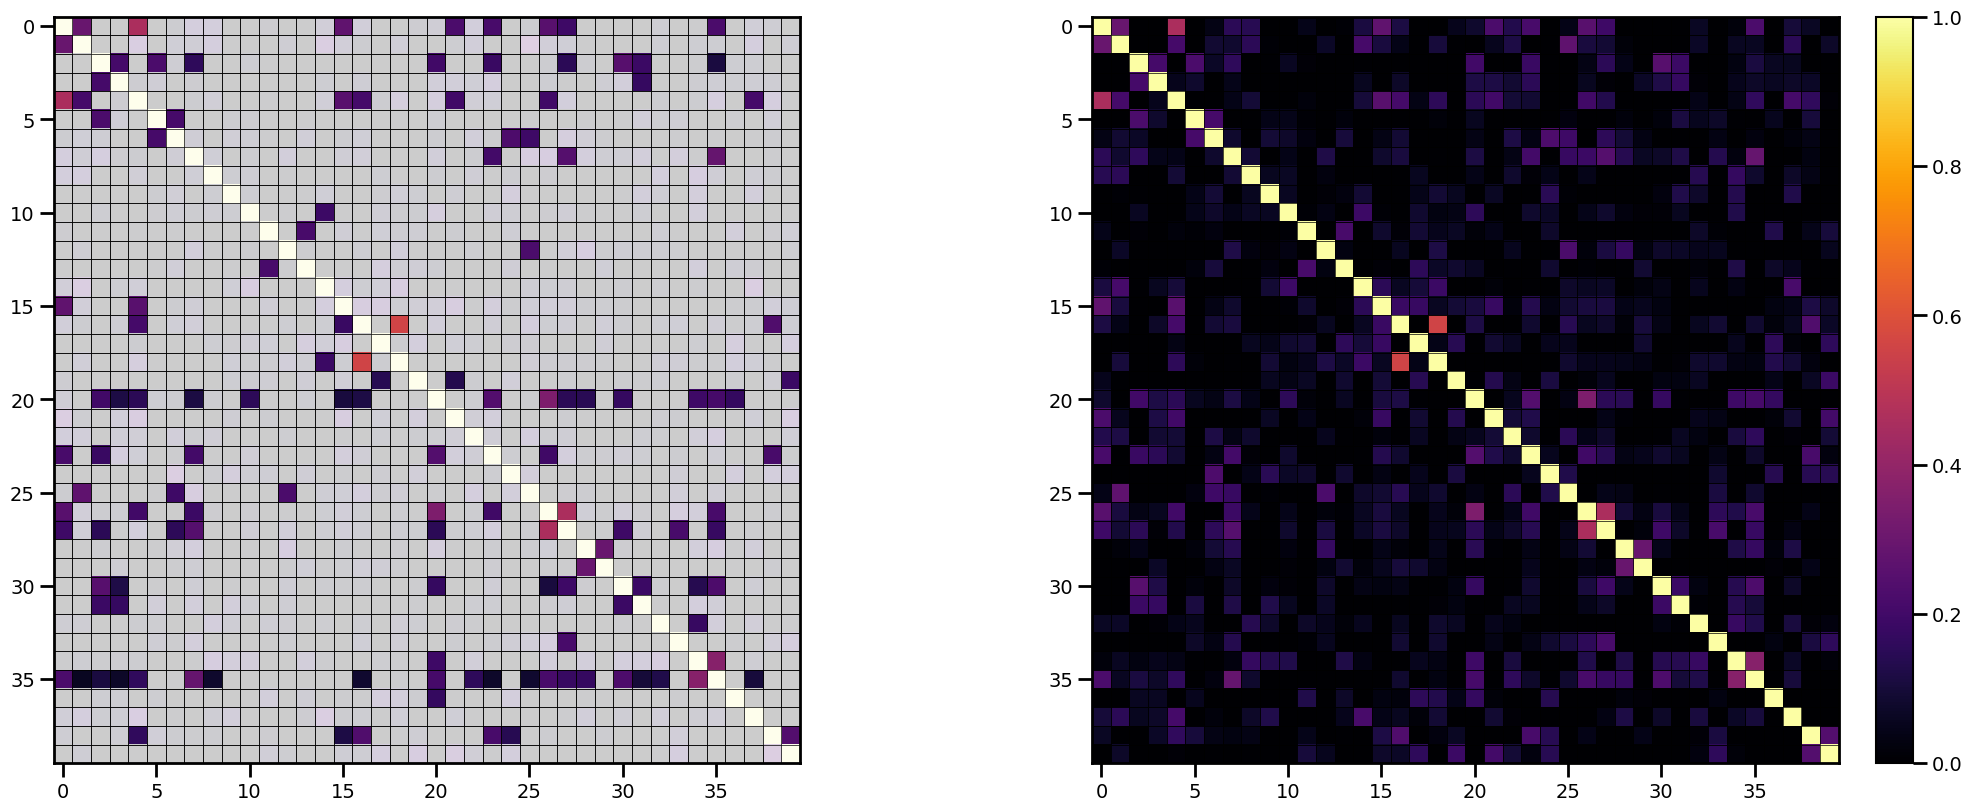

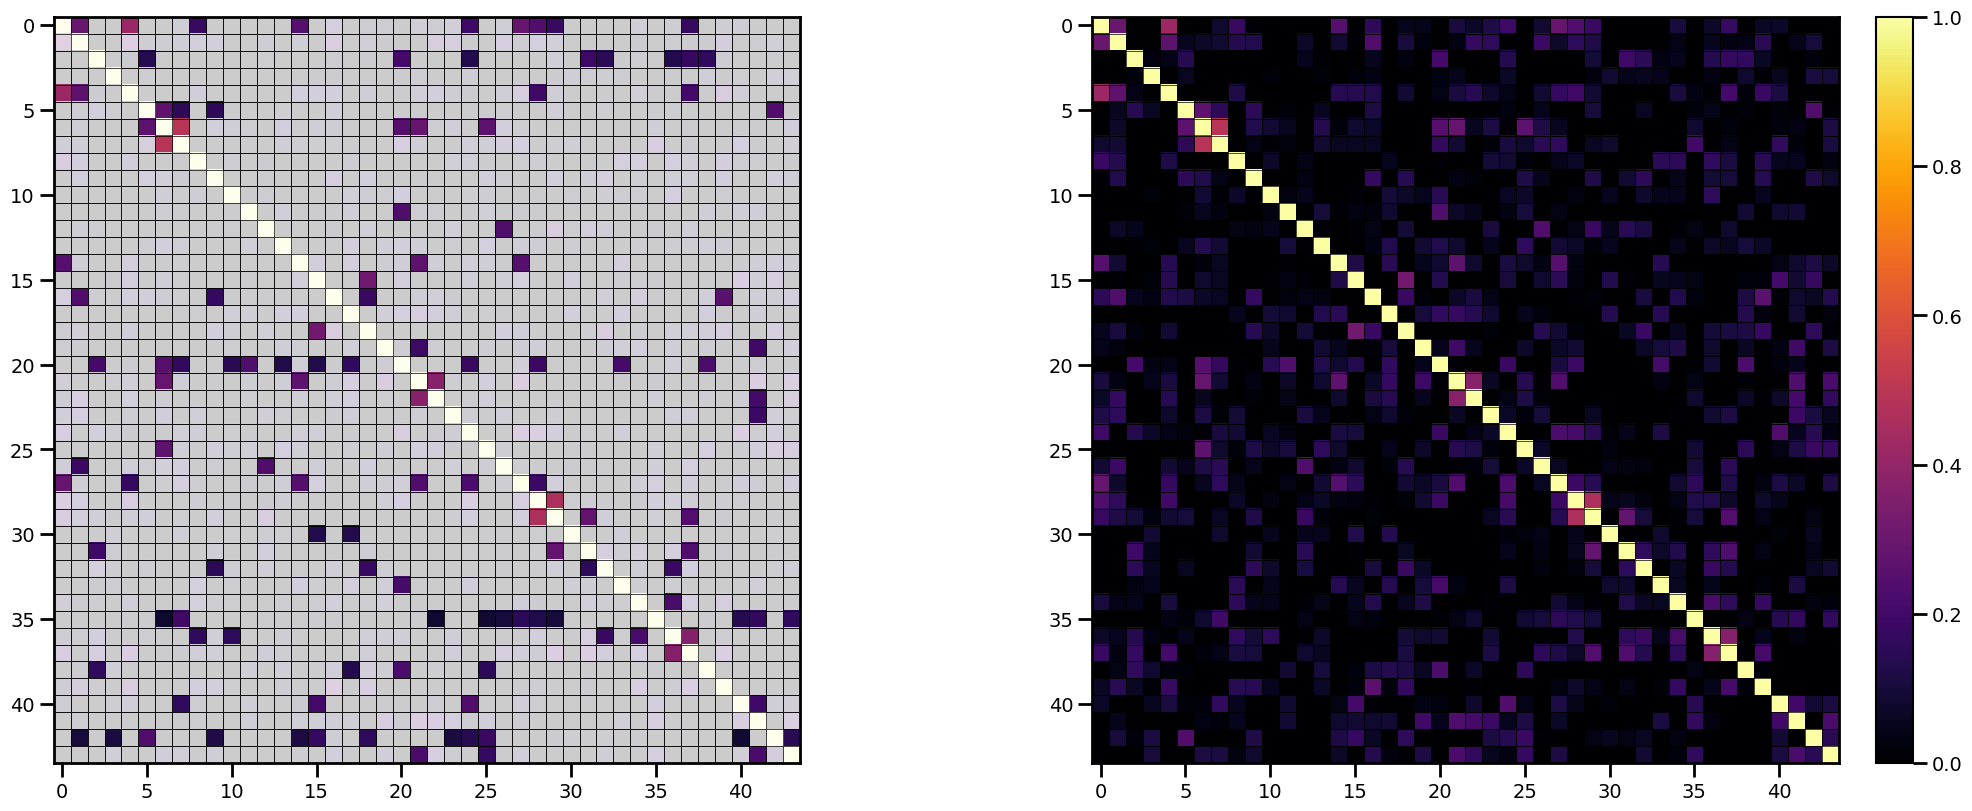

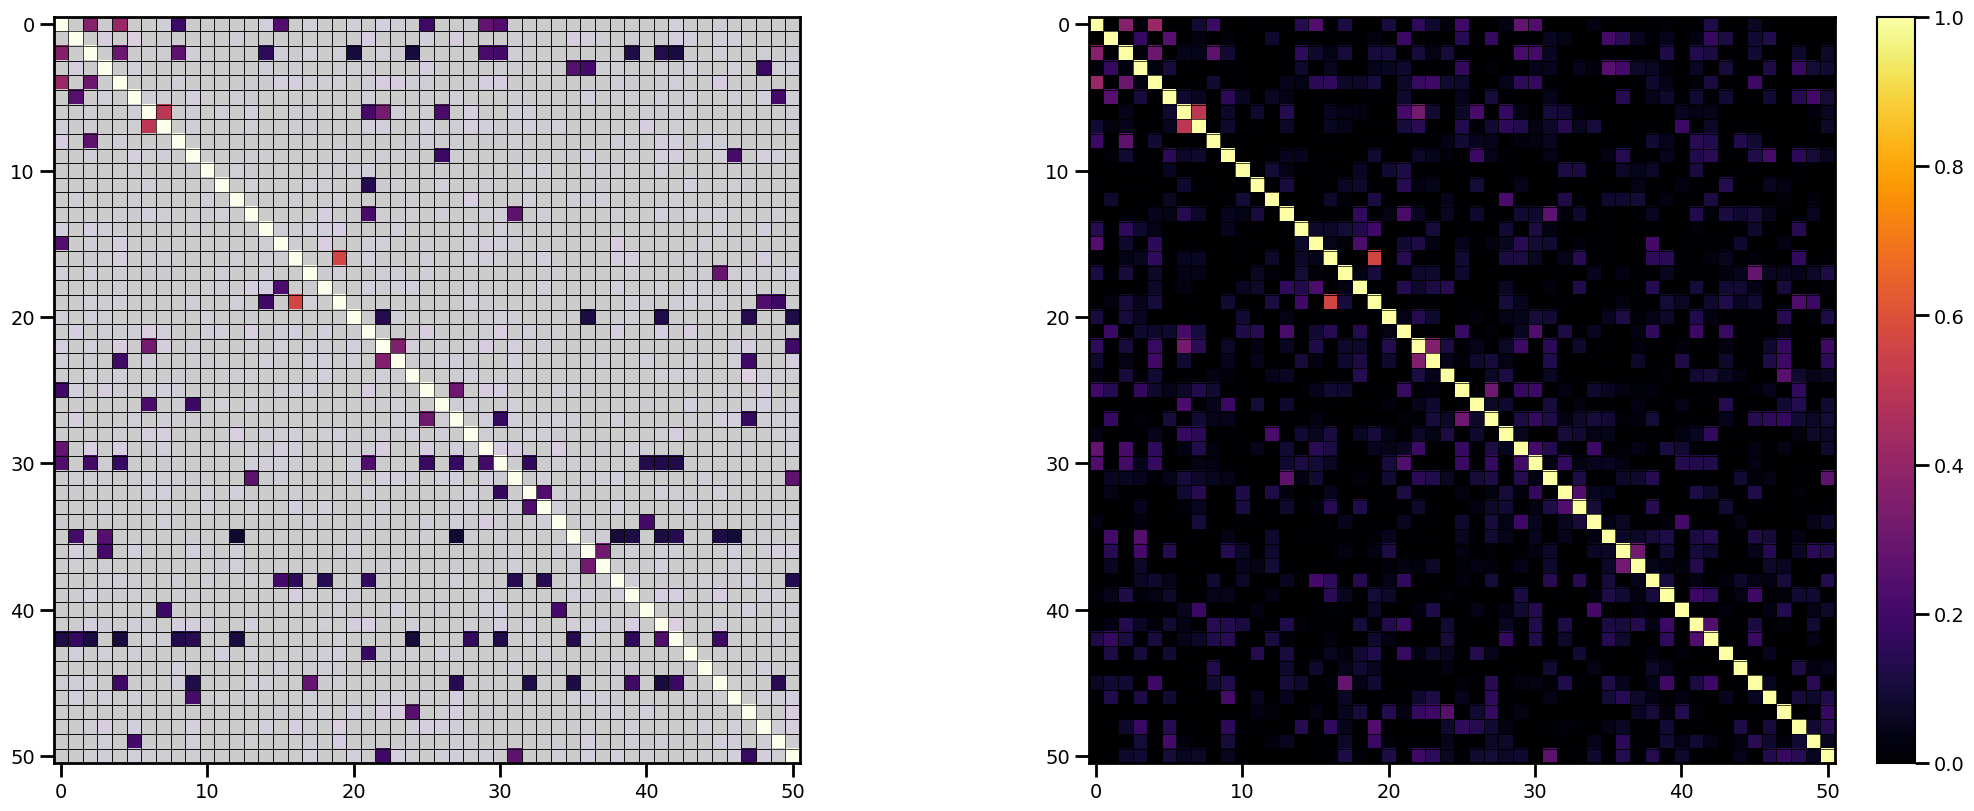

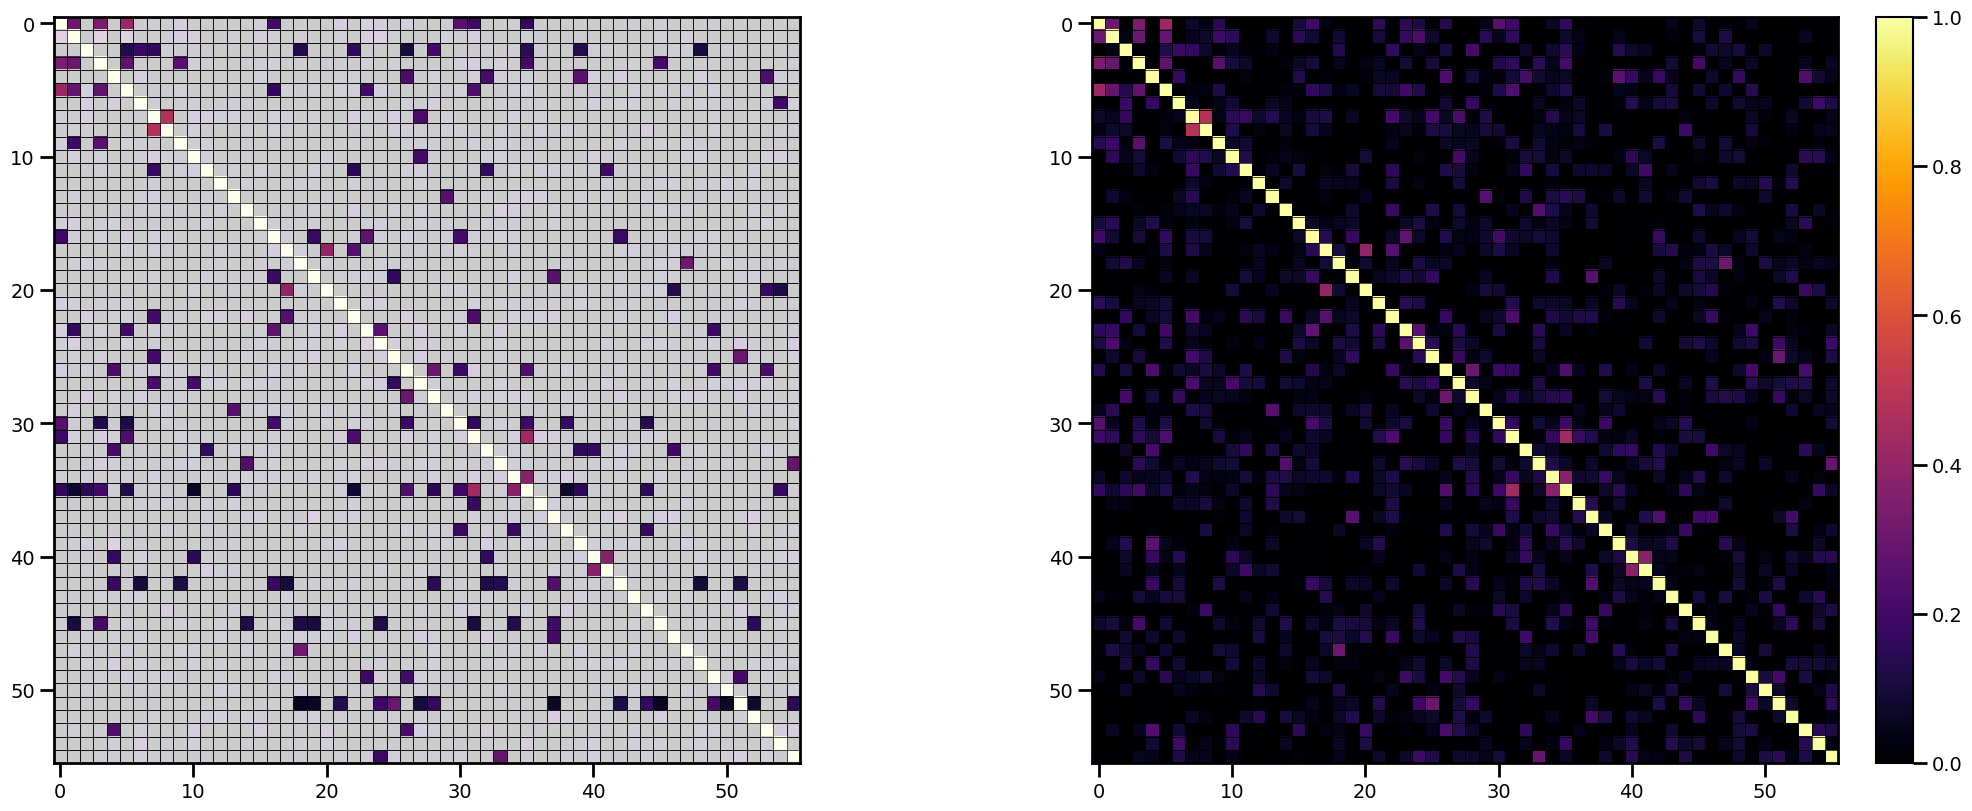

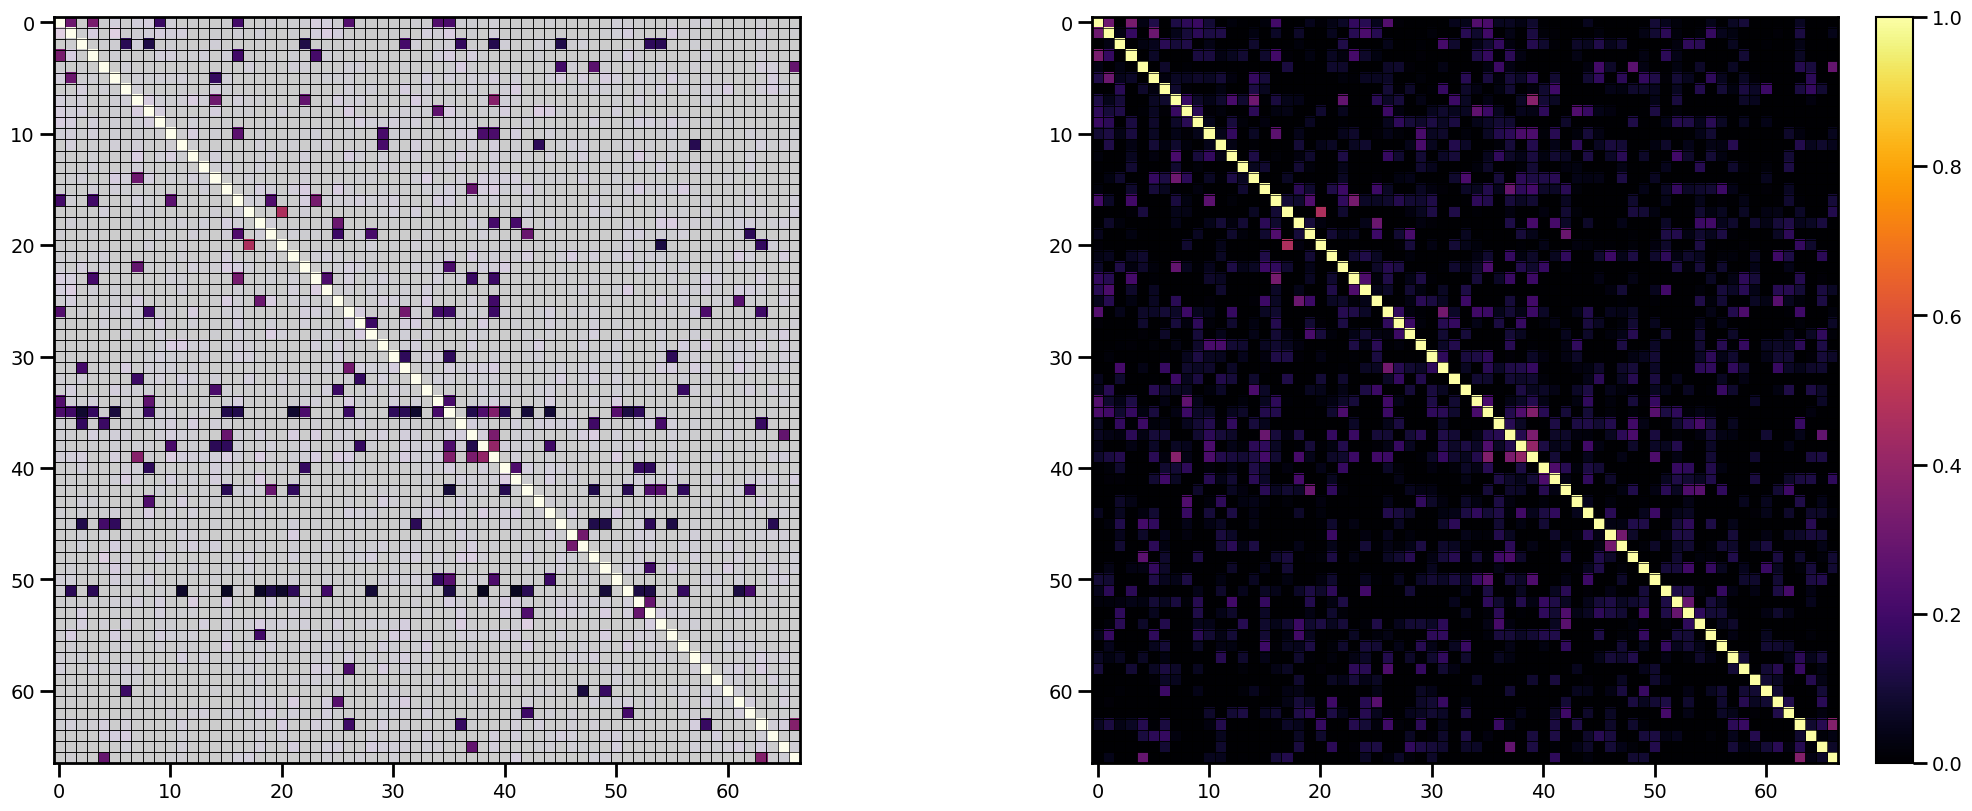

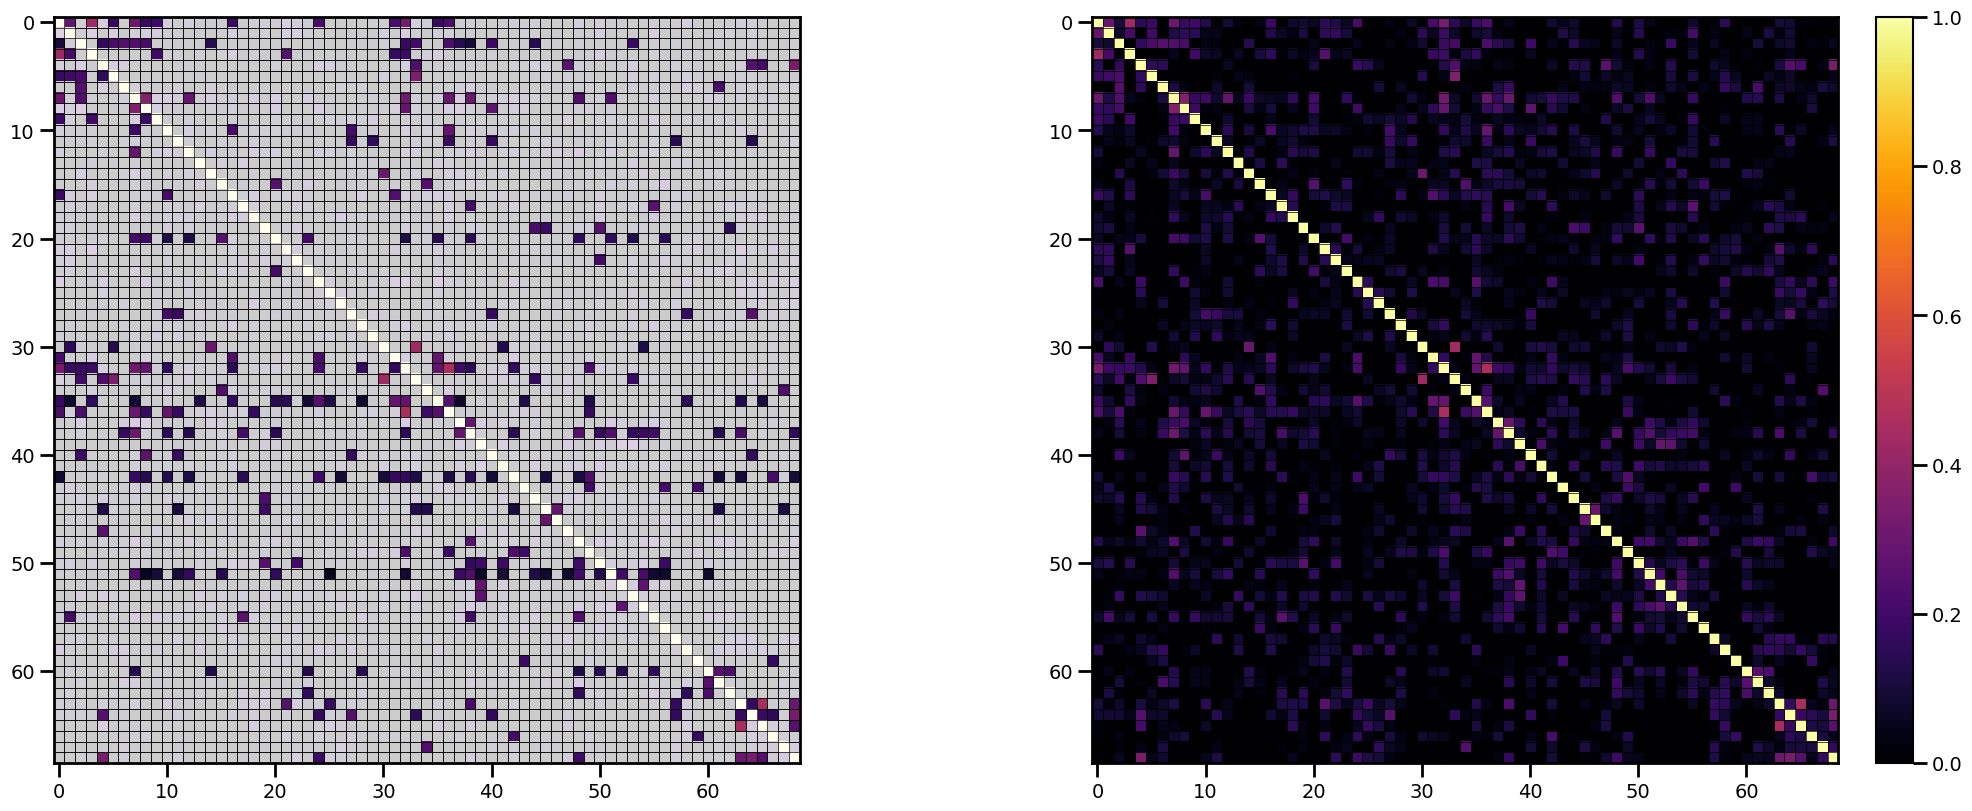

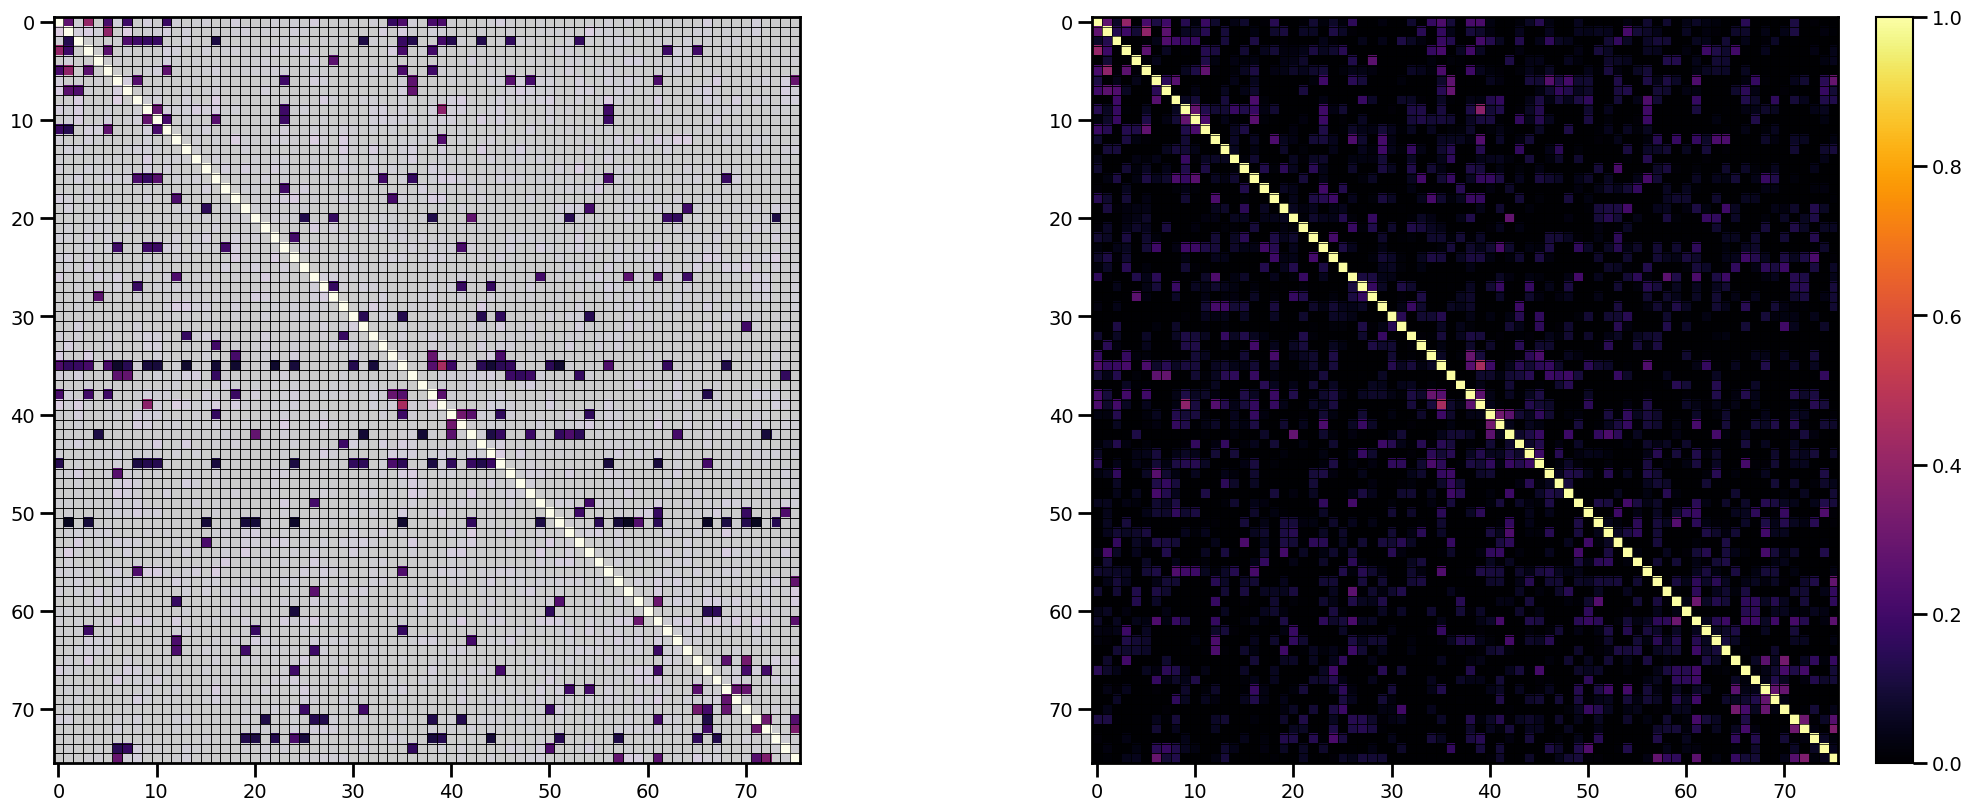

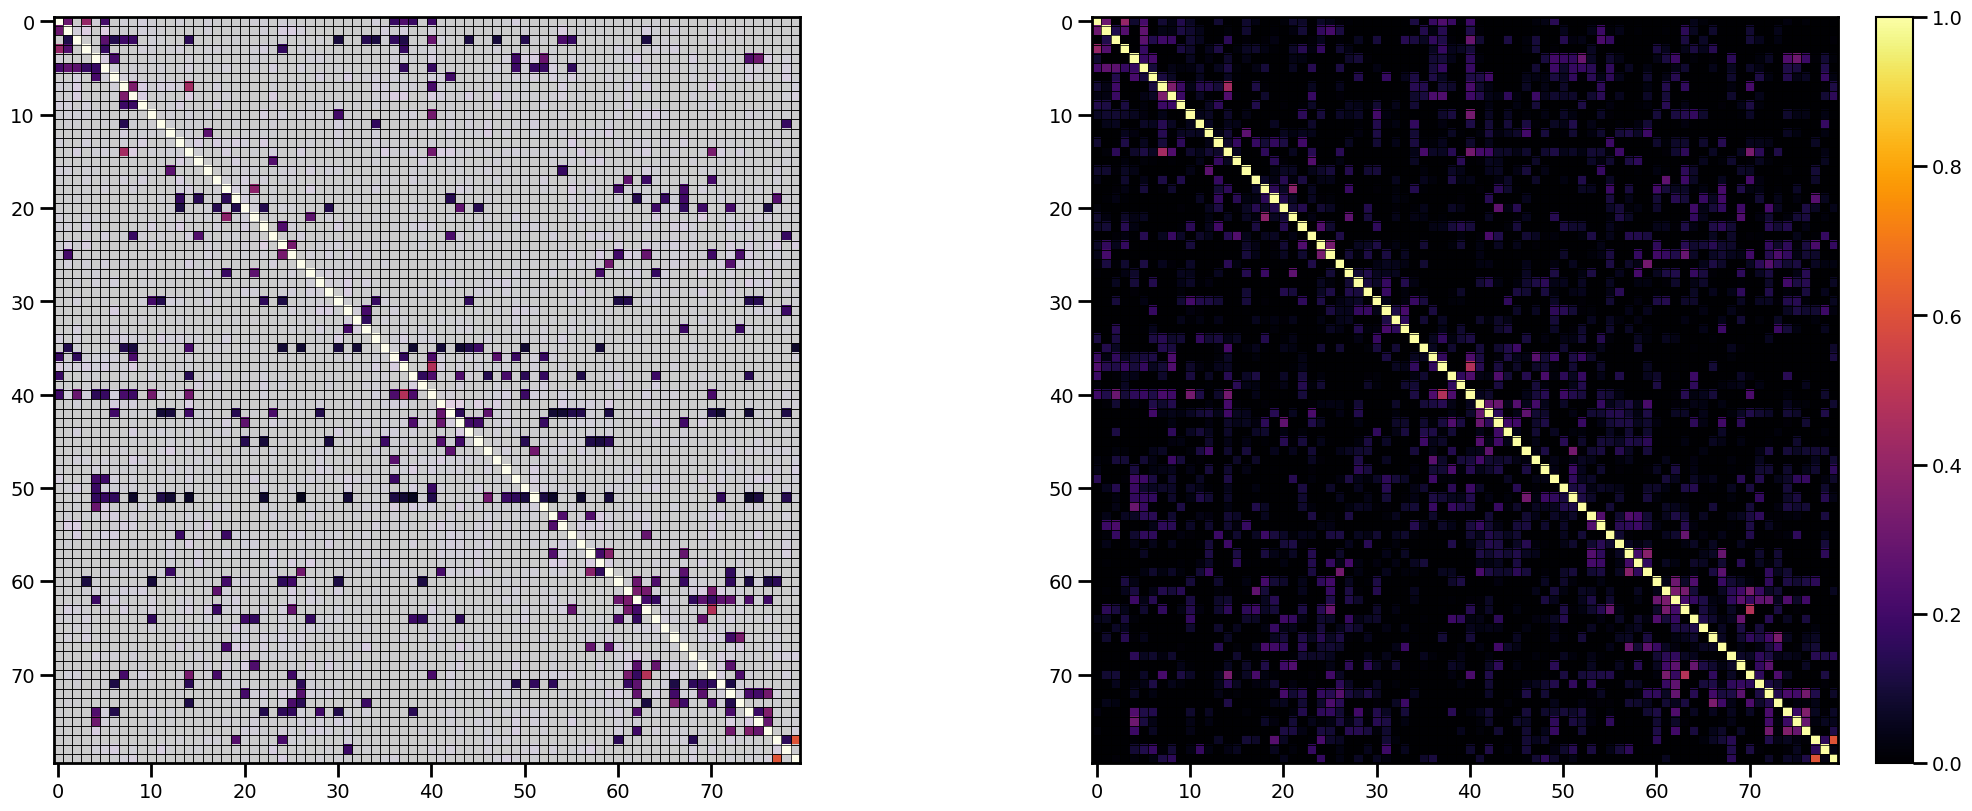

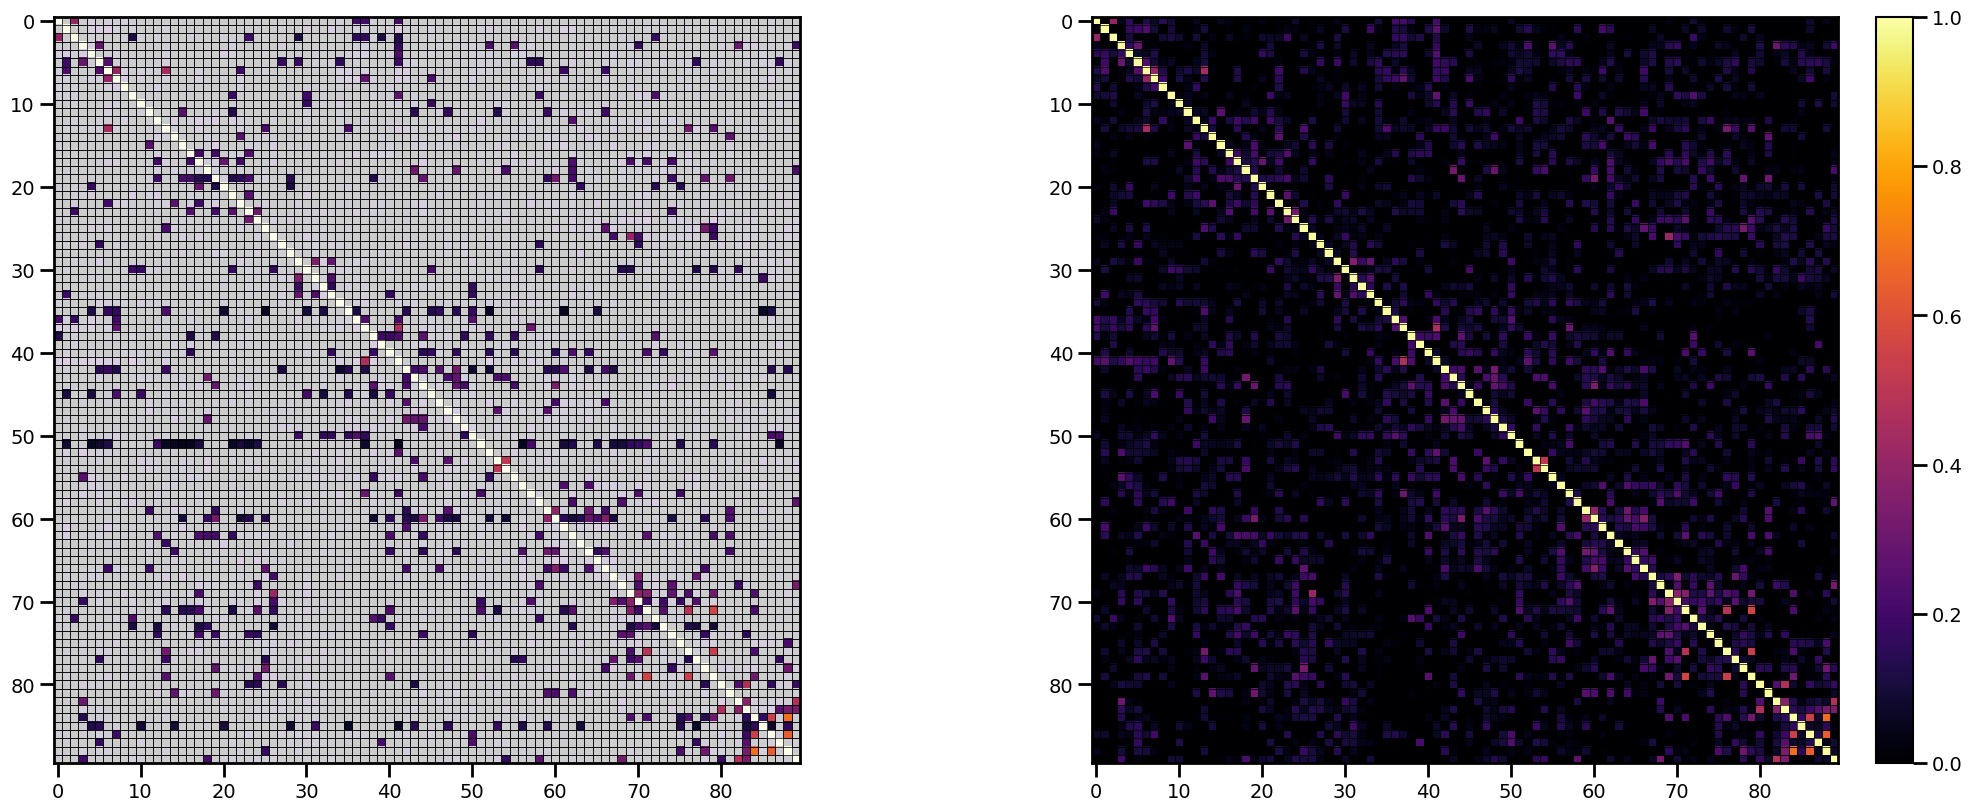

In [110]:
for year in years:
    # === 4. Plot: dendrogramma + heatmap === #

    # Layout: 1 riga, 2 colonne (dendro a sinistra, heatmap a destra)
    fig = plt.figure(figsize=(22, 8), constrained_layout=True)
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 5, 5], wspace=0.01)


    # --- 4.2 Heatmaps --- #
    ax_im0 = fig.add_subplot(gs[1])
    ax_im1 = fig.add_subplot(gs[2])
    # Heatmaps
    im=ax_im0.imshow(cos_rep_mats[year], cmap='inferno', vmin=0, vmax=1, alpha=alpha_matrices[year])
    ax_im1.imshow(cos_rep_mats[year], cmap='inferno', vmin=0, vmax=1)
    n=len(cos_rep_mats[year])
    # Etichette
    for i_ax, ax in enumerate([ax_im0, ax_im1]):
    
        # Annotazioni numeriche
        for i in range(n):
            for j in range(i+1, n):
                
                # Riquadri neri su ogni cella: triangolo superiore
                rect = patches.Rectangle((j - 0.5, i - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
                ax.add_patch(rect)
            
                # Riquadri neri su ogni cella: triangolo inferiore
                rect = patches.Rectangle((i - 0.5, j - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
                ax.add_patch(rect)
            
            
    ax.grid(False)
    # Colorbar con bordo nero
    cbar = plt.colorbar(im, ax=ax_im1, fraction=0.046, pad=0.04)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1.5)


    plt.savefig(f'./NewPlots/internal_similarity_reports_{year}_all.png', dpi=300)
    plt.show()

### Last plots

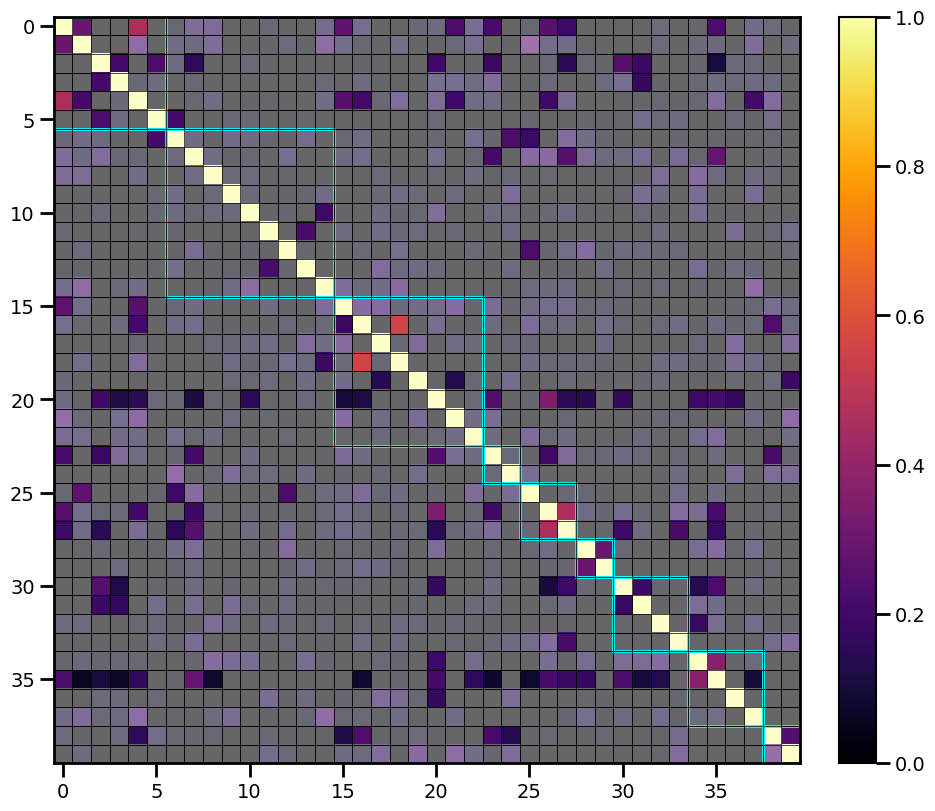

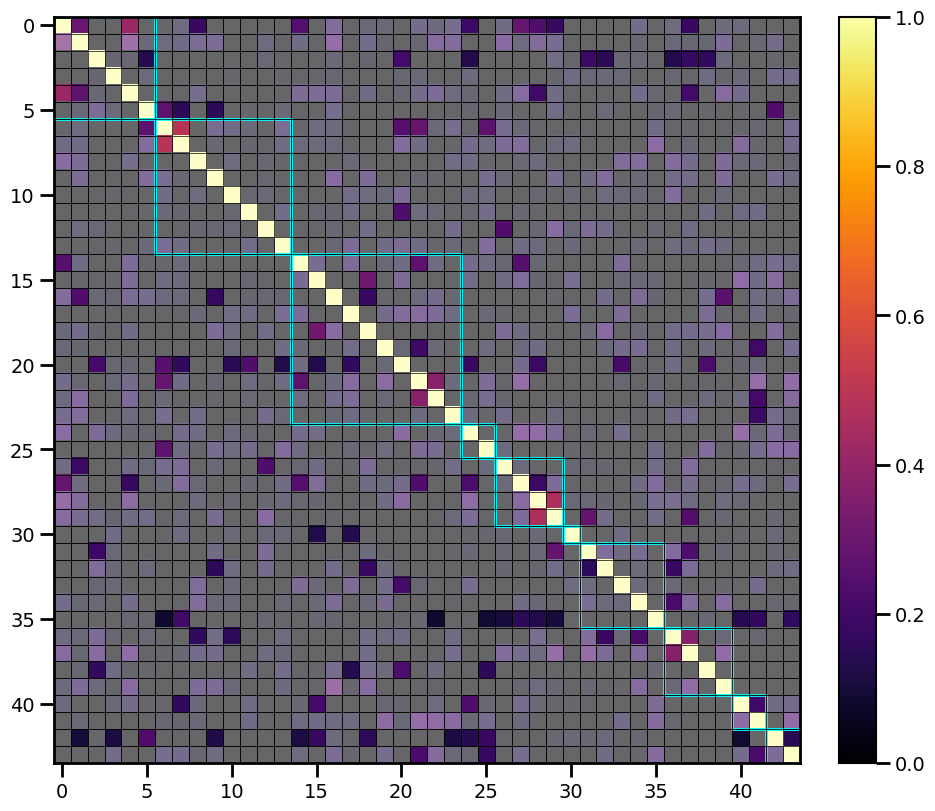

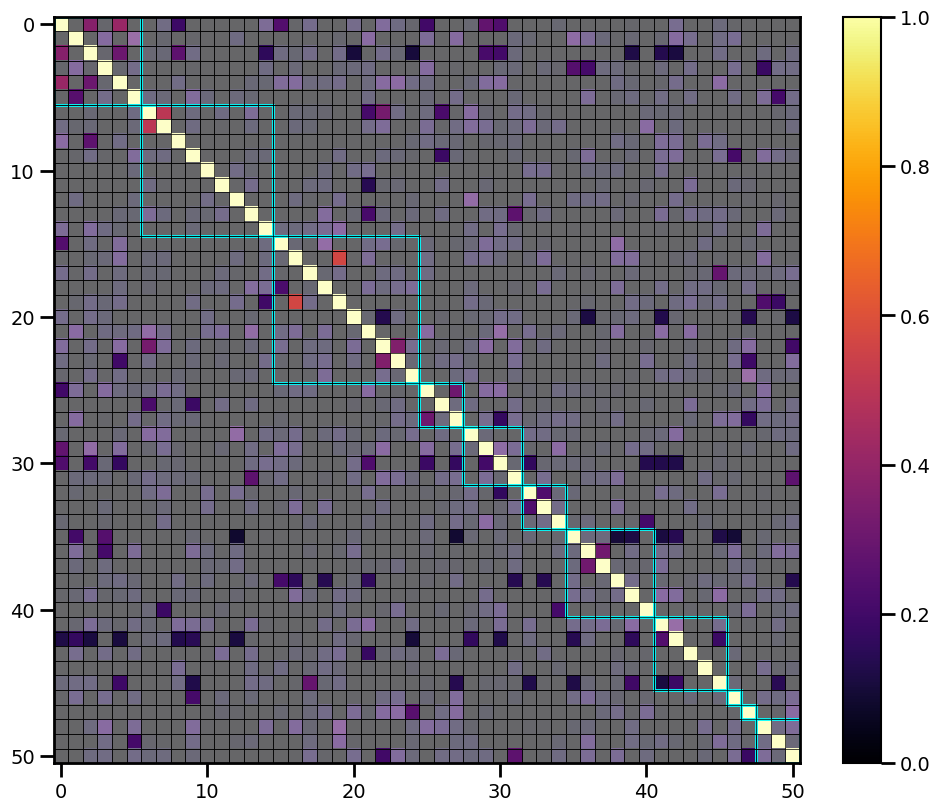

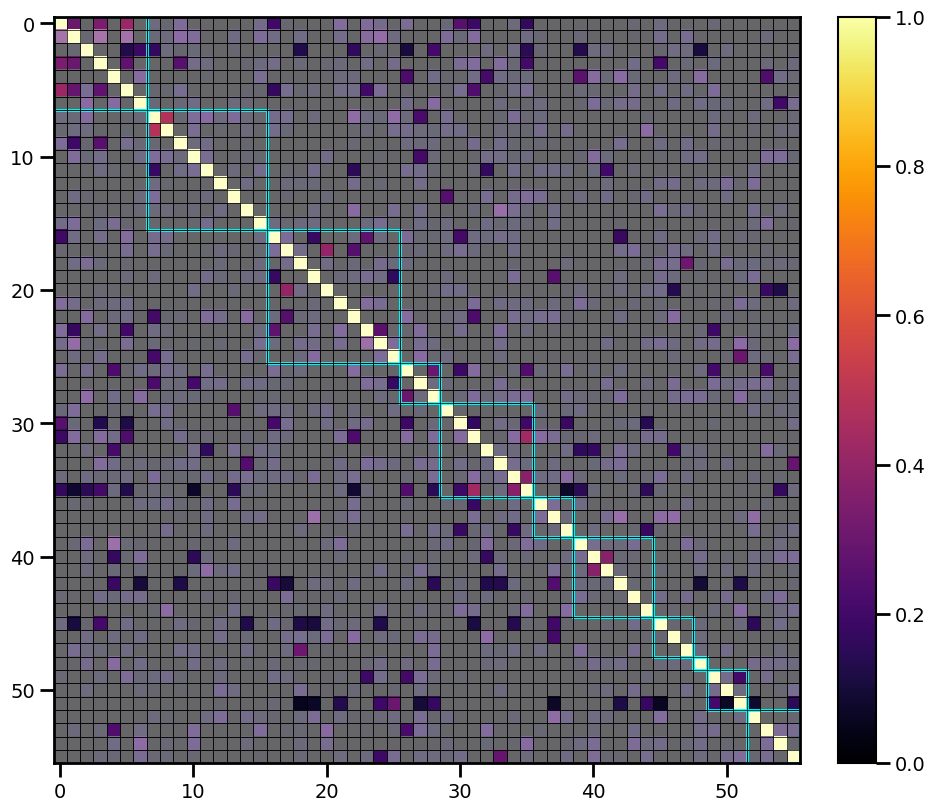

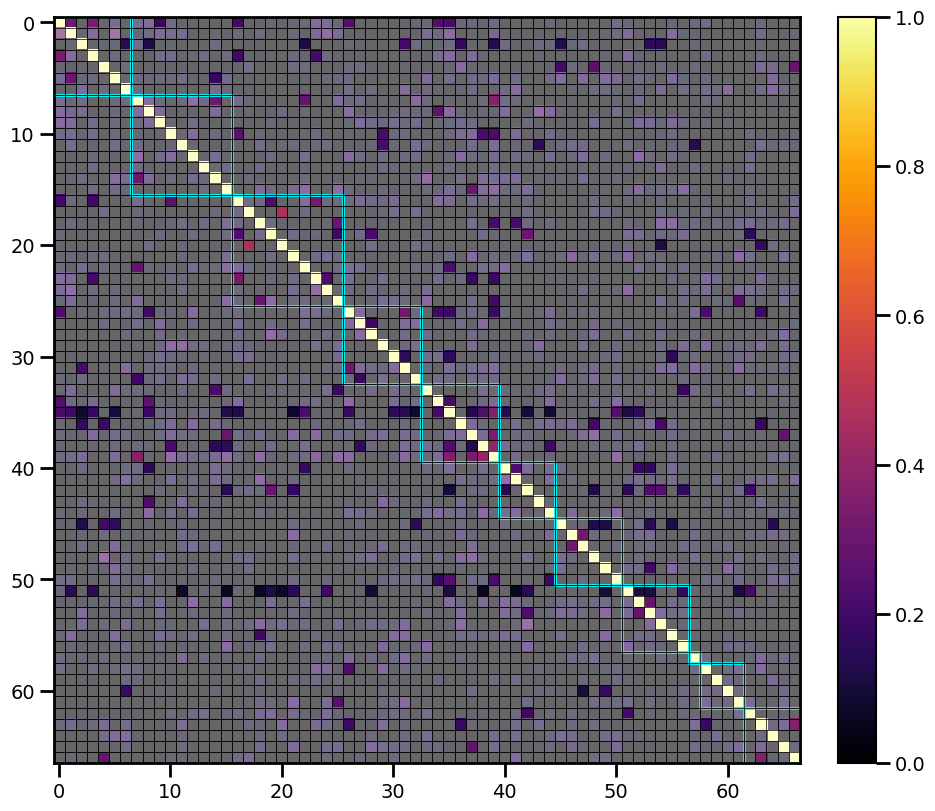

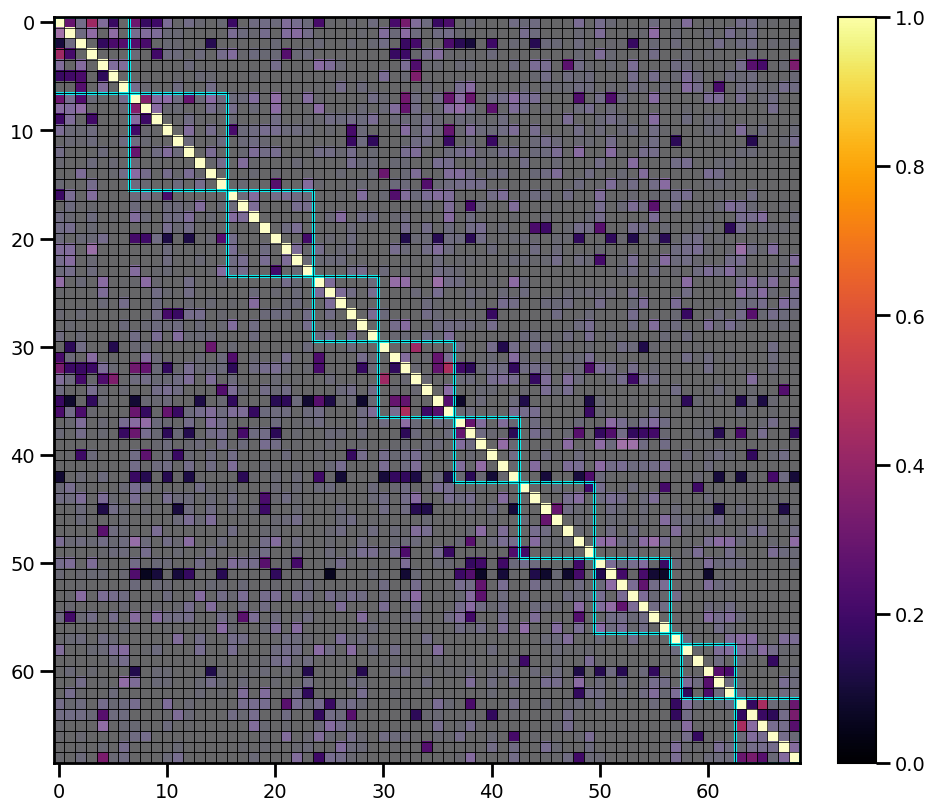

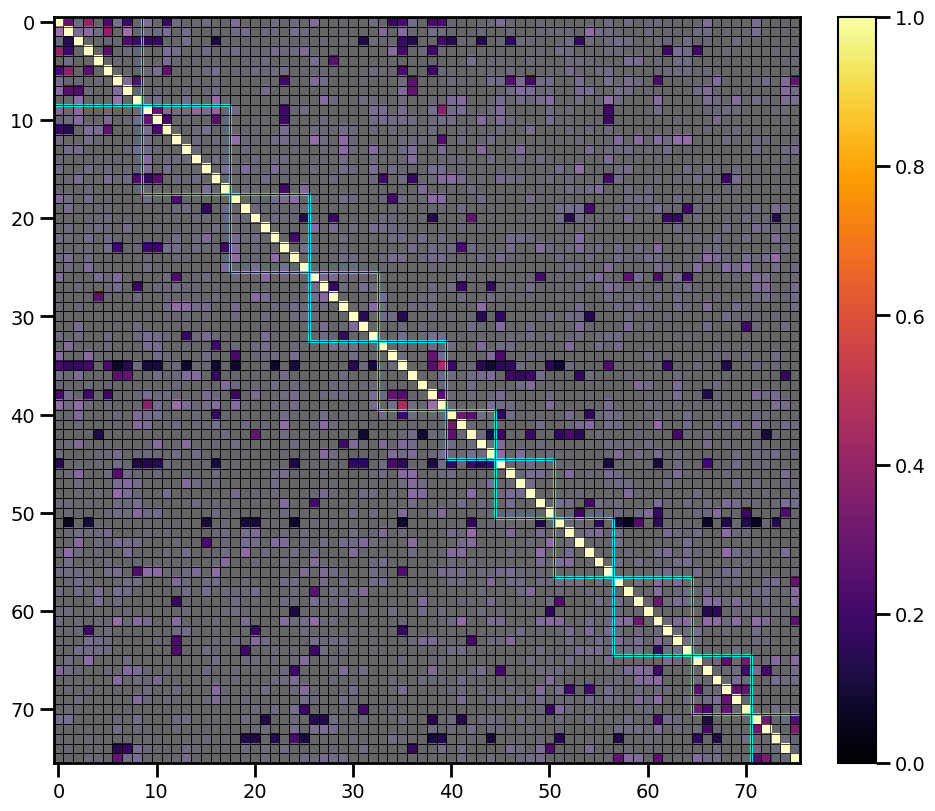

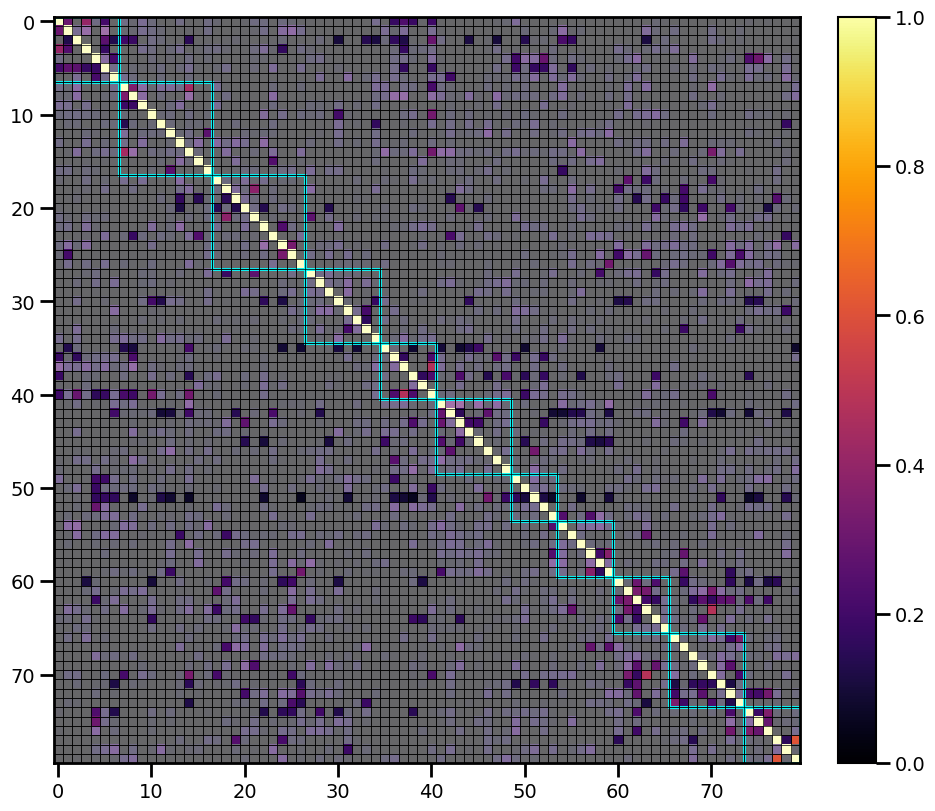

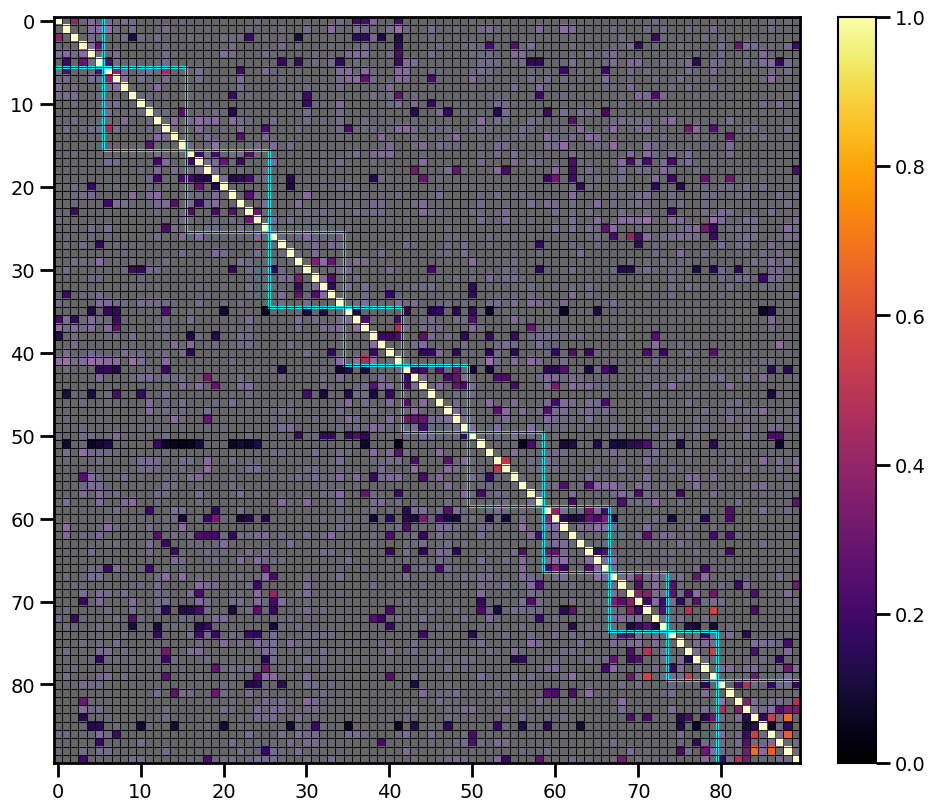

In [187]:
for year in years:

    # === 3. Blocchi (cluster) === #
    blocks = []
    val_prev = '01'
    prev=0
    start = 0
    for i, val in enumerate(sect_y[year]):
        if val != val_prev:
            blocks.append((start, i, prev))
            start = i
        
        val_prev = val
        prev=start
    blocks.append((start, len(sect_y[year]), prev))


    fig = plt.figure(figsize=(11, 8), constrained_layout=True)
    im = plt.imshow(cos_rep_mats[year], cmap='inferno', vmin=0, vmax=1, alpha=alpha_matrices[year])
    # Rettangoli lime attorno ai blocchi di ax_im0

    ax = plt.gca()
    n=len(cos_rep_mats[year])
    # Blocchi
    for start, end, cluster_id in blocks:
        width = end - start
        rect = patches.Rectangle((start - 0.5, start - 0.5), width, width,
                             linewidth=2, edgecolor='cyan', facecolor='none')
        ax.add_patch(rect)

    
    # Annotazioni numeriche
    for i in range(n):
        for j in range(i+1, n):
            val = cos_rep_mats[year][i, j]
            #plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            #plt.text(i, j, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)
            
            # Riquadri neri su ogni cella: triangolo superiore
            rect = patches.Rectangle((j - 0.5, i - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            
            # Riquadri neri su ogni cella: triangolo inferiore
            rect = patches.Rectangle((i - 0.5, j - 0.5), 1.0, 1.0,
                                 linewidth=0.5, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            
            
    plt.grid(False)
    # Colorbar con bordo nero
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1.5)

    plt.savefig(f'./NewPlots/internal_similarity_reports_{year}_w_sects.png', dpi=300)
    plt.show()

#### Extra point

In [265]:
year=2023

In [268]:
secs=list(sec_helper.keys())
secs.sort()

In [269]:
secs

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']

In [296]:
in_val_freq=np.zeros(len(secs))
out_val_freq=np.zeros(len(secs))
for i_s, sec in enumerate(secs):
    w_sec=np.where(sect_y[year]==sec)[0]
    first_node=w_sec[0]
    last_node=w_sec[-1]

    w_sec=np.where(sect_y[year]==sec)[0]
    first_node=w_sec[0]
    last_node=w_sec[-1]

    alpha_in=alpha_matrices[year][first_node:last_node+1, first_node:last_node+1]

    assert alpha_in.shape==(len(w_sec),len(w_sec))

    alpha_out_0=alpha_matrices[year][first_node:last_node+1, :first_node]
    alpha_out_1=alpha_matrices[year][first_node:last_node+1, last_node:]
    alpha_out_2=alpha_matrices[year][:first_node, first_node:last_node+1]
    alpha_out_3=alpha_matrices[year][last_node:, first_node:last_node+1]

    in_val_freq[i_s]=np.sum(alpha_in==1.)/len(w_sec)/(len(w_sec)-1)

    out_val=sum([np.sum(alpha_out==1.) for alpha_out in [alpha_out_0, alpha_out_1, alpha_out_2, alpha_out_3]])

    out_den=sum([np.prod(alpha_out.shape) for alpha_out in [alpha_out_0, alpha_out_1, alpha_out_2, alpha_out_3]])

    out_val_freq[i_s]=out_val/out_den

In [299]:
np.vstack((1+np.arange(len(secs)),in_val_freq, out_val_freq)).T

array([[ 1.        ,  0.16666667,  0.05490196],
       [ 2.        ,  0.06666667,  0.04567901],
       [ 3.        ,  0.23333333,  0.05432099],
       [ 4.        ,  0.125     ,  0.03252033],
       [ 5.        ,  0.21428571,  0.07738095],
       [ 6.        ,  0.26785714,  0.06099398],
       [ 7.        ,  0.08333333,  0.06436314],
       [ 8.        ,  0.32142857,  0.07379518],
       [ 9.        ,  0.38095238,  0.07823129],
       [10.        ,  0.16666667,  0.07745098],
       [11.        ,  0.32222222,  0.05308642]])

# Another way to look at the temporal evolution

In [133]:
uni_comp, k_uni_comp=np.unique(vectors['company'], return_counts=True)

In [134]:
np.max(k_uni_comp)

9

In [136]:
good_comps=uni_comp[k_uni_comp==9]

In [139]:
len(good_comps)

29

In [154]:
val_coherence={}
for gc in tqdm(good_comps):
    vec_gc=vectors[vectors['company']==gc]
    bench_gc=wiki_bench[vectors['company']==gc]
    _out=np.zeros(len(years)-1, dtype=[('year', int), ('cos', float), ('cos_p', float)])
    for i_y, year in enumerate(years[1:]):
        vec_y=vec_gc[vec_gc['year']==year]['vector'][0]
        bench_gc_y=bench_gc[vec_gc['year']==year][0][0]
        vec_y_1=vec_gc[vec_gc['year']==year-1]['vector'][0]
        cos_y_y_1=float(util.cos_sim(vec_y, vec_y_1))
        cos_y_y_1_p=np.sum(bench_gc_y>=cos_y_y_1)/4001
        _out[i_y]['year']=year
        _out[i_y]['cos']=cos_y_y_1
        _out[i_y]['cos_p']=cos_y_y_1_p
    val_coherence[gc]=_out

  0%|          | 0/29 [00:00<?, ?it/s]

In [161]:
for gc in tqdm(good_comps):
    non_zero_p_vals=val_coherence[gc]['cos_p']>0
    if np.sum(non_zero_p_vals)>0:
        print(gc, val_coherence[gc][non_zero_p_vals]['year'], val_coherence[gc][non_zero_p_vals]['cos'], val_coherence[gc][non_zero_p_vals]['cos_p'])

  0%|          | 0/29 [00:00<?, ?it/s]

shaftesbury_capital [2022] [0.18337301] [0.13221695]


In [162]:
val_coherence['shaftesbury_capital']

array([(2016, 0.91172249, 0.        ), (2017, 0.9231866 , 0.        ),
       (2018, 0.94793071, 0.        ), (2019, 0.87065695, 0.        ),
       (2020, 0.87438333, 0.        ), (2021, 0.95565314, 0.        ),
       (2022, 0.18337301, 0.13221695), (2023, 0.76373824, 0.        )],
      dtype=[('year', '<i8'), ('cos', '<f8'), ('cos_p', '<f8')])

In [163]:
np.unique(vectors[vectors['company']=='shaftesbury_capital']['sector'])

array(['08'], dtype='<U2')